**Table of contents**<a id='toc0_'></a>    
- [Some figures is in the SpinVet_fit_diff_plot.ipynb](#toc1_)    
- [Define functions](#toc2_)    
  - [Const and ff](#toc2_1_)    
  - [nn Jex](#toc2_2_)    
  - [nn Jex and Dip](#toc2_3_)    
  - [nn Jex and Dip, Daniso](#toc2_4_)    
  - [Reproduce the nn FM, AFM, dipole results from Kadowaki et al. Phys. Rev. B 65 144421](#toc2_5_)    
  - [3nn](#toc2_6_)    
    - [Find neighbors](#toc2_6_1_)    
    - [3nn: J1-3， Dip1-3](#toc2_6_2_)    
    - [3NN: J1-3, Dip1-3, Daniso](#toc2_6_3_)    
- [HHL plane and Powder](#toc3_)    
  - [HHL plane](#toc3_1_)    
  - [Reproduce P. H. Conlon and J. T. Chalker PRB 81, 224413(2010)](#toc3_2_)    
  - [Powder](#toc3_3_)    
- [Calc and plot SqPowder](#toc4_)    
  - [Compare with matlab and julia](#toc4_1_)    
- [Load data and fitting](#toc5_)    
  - [Load 35mK data](#toc5_1_)    
  - [Other data (update `data` for fit)](#toc5_2_)    
- [Fit 3nn with Da](#toc6_)    
    - [Define fit function](#toc6_1_1_)    
  - [Fit with fixed Da and Dip](#toc6_2_)    
    - [Plot](#toc6_2_1_)    
    - [Fit J0 and fixed Dip, Da and J1=j2a=J2b=0](#toc6_2_2_)    
    - [Fit J0, J1 with fixed Dip, Da, and J2a=J2b=0](#toc6_2_3_)    
    - [Fit J0, J2b with fixed Dip, Da, and J1=J2a=0](#toc6_2_4_)    
    - [Fit J0, J2a with fixed Dip, Da, and J1=J2b=0](#toc6_2_5_)    
    - [Fit J0, J1, J2b with fixed Dip, Dia and j2a=0](#toc6_2_6_)    
    - [Fit J0, J1, J2a with fixed Dip, Dia and j2b=0](#toc6_2_7_)    
    - [Fit J0, J1, J2a, J2b with fixed Dip, Dia](#toc6_2_8_)    
  - [Fit Da, Jex0, Jex1, T (fixed 1-3nn Dipole and Jex2a=Jex2b=0)](#toc6_3_)    
- [Fit 3nn with Da==0](#toc7_)    
    - [Fit only nn Jex (fixed 1-3nn Dipole)](#toc7_1_1_)    
    - [Fit Jex(1nn, 2nn, 3nn_a/b) (fixed 1-3nn Dipole)](#toc7_1_2_)    
    - [The good plot](#toc7_1_3_)    
  - [Fit Jex(1nn) (fixed 1-3nn dipolar and Jex(2nn,3nn)=0)](#toc7_2_)    
- [Fit nn Jex and Dip](#toc8_)    
  - [Fit nn Jex and Dip](#toc8_1_)    
  - [Fit only nn Jex](#toc8_2_)    
- [Random fitting](#toc9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Some figures is in the SpinVet_fit_diff_plot.ipynb](#toc0_)

In [1]:
import numpy as np
from numpy import linalg as LA
from scipy import stats
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import minimize
from numba import float64,jit,prange,njit, vectorize, guvectorize
%matplotlib widget
#%matplotlib ipympl
#from cubature import cubature
from joblib import Parallel, delayed
import multiprocessing
multiprocessing.cpu_count()
import time
from itertools import product, combinations_with_replacement
from numpy import linalg as LA
import os
#import pyswarms as ps

from latexify import latexify
latexify()

In [3]:
# # Test cubature
# def integrand_sphere(x_array, *args):
#     r, theta, phi = x_array
#     return np.array([r**2*np.sin(phi)])

# ndim = 3
# fdim = 1
# radius = 1.
# xmin = np.array([0, 0, 0])
# xmax = np.array([radius, 2*np.pi, np.pi])

# %timeit val, err = cubature(integrand_sphere, ndim, fdim, xmin, xmax)
# print(cubature(integrand_sphere, ndim, fdim, xmin, xmax))

# %timeit val, err = integrate.nquad(lambda r, theta, phi: integrand_sphere([r, theta, phi]), [[0,1], [0,2*np.pi],[0, np.pi]],opts={'epsrel':0.01})
# print(integrate.nquad(lambda r, theta, phi: integrand_sphere([r, theta, phi]), [[0,1], [0,2*np.pi],[0, np.pi]],opts={'epsrel':0.01}))

# <a id='toc2_'></a>[Define functions](#toc0_)

## <a id='toc2_1_'></a>[Const and ff](#toc0_)

In [2]:
S = 7/2
g = 2
uB = 9.274 * 10**-24 #Am2
u0 = 4 * 3.14* 10**-7 # Tm/A 
aa = 10.4
d = aa*np.sqrt(2)/4 * 10**-10

# Dipolar interaction in meV
print(
    u0*(S*g*uB)**2 / d**3 /(4*3.14) / (1.602176634*10**-22),  # with S^2
    u0*(S*g*uB)*((S+1)*g*uB) / d**3 /(4*3.14) / (1.602176634*10**-22), # with S(S+1)
    u0*(g*uB)**2 / d**3 /(4*3.14) / (1.602176634*10**-22) # in meV without SS for SpinW
)

0.052912079732749674 0.06802981679924958 0.004319353447571402


In [3]:
# Jex from Tcw=z J S(S+1) / 3kb for H= \sum_{i<j} Jex S_i \cdot S_j
# in the Book by J W D Coey, Magnetism and magnetic materials H= 2 \sum_{i<j} Jex S_i \cdot S_j, 
# corresponding to Tcw=z 2J S(S+1) / 3kb
print(-7.3 *3 / 6/S/(S+1) /11.6, 
      -7.3 *3 / 6 /11.6,
      -8.6 *3 / 6/S/(S+1), # reproduce in Ref.[3]
      -7.3 *3 / 6 /11.6)

-0.019978106185002738 -0.3146551724137931 -0.273015873015873 -0.3146551724137931


In [6]:
"""
[1] A. Ali Biswas and Y. M. Jana, Estimation of Single-Ion Anisotropies, Crystal-Field and Exchange Interactions in Gd-Based Frustrated Pyrochlore Anti-Ferromagnets Gd2M2O7 (M=Ti, Sn, Hf, Zr), Journal Of Magnetism And Magnetic Materials 323, 3202 (2011).

[2] V. N. Glazkov, M. E. Zhitomirsky, A. I. Smirnov, H. A. Krug von Nidda, A. Loidl, C. Marin, and J. P. Sanchez, Single-Ion Anisotropy in the Gadolinium Pyrochlores Studied by Electron Paramagnetic Resonance, Physical Review B 72, 20409 (2005).

[3] A. Del Maestro and M. J. P. Gingras, Low-Temperature Specific Heat and Possible Gap to Magnetic Excitations in the Heisenberg Pyrochlore Antiferromagnet Gd 2 Sn 2 O 7, Phys. Rev. B 76, 064418 (2007).

[4] H. Kadowaki, Y. Ishii, K. Matsuhira, and Y. Hinatsu, Physical Review B 65, 144421 (2002).

1. Scaling to get the B20 for GHO in the Table I (Ref[1]): GTO and GHO; GTI in Ref.[2] because the convension factor is not known for Ref.[1,2]
   B20 for GHO: 1115/2112*74 = 39mK
   D = 3B20 without S(S+1)
J3a = 0 in Ref.[3]

2. Sigh for Jex, Dip and Ani according to Eqs 4.1-4.4, when constructing the H matrix, the signs are Jex[]-Dip[]+Ani[]
"""

'\n[1] A. Ali Biswas and Y. M. Jana, Estimation of Single-Ion Anisotropies, Crystal-Field and Exchange Interactions in Gd-Based Frustrated Pyrochlore Anti-Ferromagnets Gd2M2O7 (M=Ti, Sn, Hf, Zr), Journal Of Magnetism And Magnetic Materials 323, 3202 (2011).\n\n[2] V. N. Glazkov, M. E. Zhitomirsky, A. I. Smirnov, H. A. Krug von Nidda, A. Loidl, C. Marin, and J. P. Sanchez, Single-Ion Anisotropy in the Gadolinium Pyrochlores Studied by Electron Paramagnetic Resonance, Physical Review B 72, 20409 (2005).\n\n[3] A. Del Maestro and M. J. P. Gingras, Low-Temperature Specific Heat and Possible Gap to Magnetic Excitations in the Heisenberg Pyrochlore Antiferromagnet Gd 2 Sn 2 O 7, Phys. Rev. B 76, 064418 (2007).\n\n[4] H. Kadowaki, Y. Ishii, K. Matsuhira, and Y. Hinatsu, Physical Review B 65, 144421 (2002).\n\n1. Scaling to get the B20 for GHO in the Table I (Ref[1]): GTO and GHO; GTI in Ref.[2] because the convension factor is not known for Ref.[1,2]\n   B20 for GHO: 1115/2112*74 = 39mK\nJ3a 

In [16]:
0.039/11.6*3.5*3.5

0.04118534482758621

In [3]:
kb = 0.0862
JexGd = -0.3 #meV; -0.166 # including S(S+1)
DipGd = 0.066 # including S(S+1), there is a minus sign in the interaction matrix
DanGd = 0.14/11.6 * 3.5*3.5 #meV, need to include S(S+1) found on 2024.03.21

# Atom positions
r0=np.array([0, 0, 0])/4
r1=np.array([1, 1, 0])/4
r2=np.array([1, 0, 1])/4
r3=np.array([0, 1, 1])/4
rs=np.vstack([r0,r1,r2,r3]).T
print(rs)

# Loacal 111 aixs
n0=[1, 1, 1]
n1=[-1, -1, 1]
n2=[-1, 1, -1]
n3=[1, -1, -1]
ns = np.vstack([n0,n1,n2,n3])/np.sqrt(3)
print(ns)

[[0.   0.25 0.25 0.  ]
 [0.   0.25 0.   0.25]
 [0.   0.   0.25 0.25]]
[[ 0.57735027  0.57735027  0.57735027]
 [-0.57735027 -0.57735027  0.57735027]
 [-0.57735027  0.57735027 -0.57735027]
 [ 0.57735027 -0.57735027 -0.57735027]]


In [4]:
def gdformfact(q):# Gd3+ form factor
    s,j,l,ss = q/(4*np.pi), 7/2., 0, 7/2. ### Take care of the fraction 9/2=4
    fc = (j*(j+1)-ss*(ss+1)+l*(l+1))/(3*j*(j+1)+ss*(ss+1)-l*(l+1))
    
    j0 = [0.0186,25.3867,0.2895,11.1421,0.7135,3.7520,-0.0217]
    j2 = [0.3347,18.4758,1.2465,6.8767,0.9537,2.3184,0.0217]
    
    fm = (j0[0]*np.exp(-j0[1]*s**2) + j0[2]*np.exp(-j0[3]*s**2)+j0[4]*np.exp(-j0[5]*s**2) + j0[6] 
          + s**2*(j2[0]*np.exp(-j2[1]*s**2)+j2[2]*np.exp(-j2[3]*s**2)+j2[4]*np.exp(-j2[5]*s**2)+j2[6])*fc)
    return fm**2

## <a id='toc2_2_'></a>[nn Jex](#toc0_)

In [5]:
def Sq(Q, Jex, T):
    phase = 2*np.real( np.exp(1j * Q@rs).T.reshape([4,1]) @ np.exp(-1j*Q@rs).reshape([1,4]) )
    np.fill_diagonal(phase, 0)
    val, vec = LA.eigh(Jex*phase) # eigh: orthorgnal vec for symmetric matirx; eig does not.
    return np.sum( np.sum(vec, axis=0)**2 / (3*T*kb - val) )

#from numba import array(float64, 1d, A)
@jit(float64(float64[::1], float64, float64), fastmath=True, nopython=True, cache=True)#[::1] for declareing 1D continius array 
def SqFast(Q, Jex, T):
    #phase = 2*np.real( np.exp(1j * Q@rs).T.reshape([4,1]) @ np.exp(-1j*Q@rs).reshape([1,4]) )
    phase = 2*np.array([np.cos(Q@(r1-r2)) for r1 in rs.T for r2 in rs.T]).reshape(4,4)
    np.fill_diagonal(phase, 0)
    val, vec = LA.eigh(Jex*phase) # eigh: orthorgnal vec for symmetric matirx; eig does not.
    return np.sum( np.sum(vec, axis=0)**2 / (3*T*kb - val) )

@jit(float64(float64, float64, float64, float64, float64), nopython=True, cache=True)
def SqPolar(q, th, phi, Jex, T):
    return SqFast(np.array([q*np.sin(th)*np.cos(phi), q*np.sin(th)*np.sin(phi), q*np.cos(th)]), Jex, T)*np.sin(th)

#@jit(float64(float64, float64, float64), nopython=True, cache=True)
#@jit(nopython=True)
# nuba: Cannot capture the non-constant value associated with variable 'Jex' in a function that will escape.
def SqPowder_cub(q, Jex, T):
    #return integrate.nquad(lambda th, phi:  SqPolar(q, th, phi, Jex, T), [[0, np.pi/2],[0, np.pi/4]])[0]
    #return cubature(lambda thphi: SqPolar(q, thphi[0], thphi[1], Jex, T), 2, 1, [0,0], [np.pi/2, np.pi/4]) # run time: 17ms
    return cubature(lambda thphi: Sq(np.array([q*np.sin(thphi[0])*np.cos(thphi[1]), q*np.sin(thphi[0])*np.sin(thphi[1]), q*np.cos(thphi[0])]), Jex, T)*np.sin(thphi[0]), 2, 1, [0,0], [np.pi/2, np.pi/4]) # run time: 76ms
    #return cubature(lambda thphi: SqFast(np.array([q*np.sin(thphi[0])*np.cos(thphi[1]), q*np.sin(thphi[0])*np.sin(thphi[1]), q*np.cos(thphi[0])]), Jex, T)*np.sin(thphi[0]), 2, 1, [0,0], [np.pi/2, np.pi/4]) # run time: 31ms

def SqPowder(q, Jex, T): # 11ms
    return integrate.nquad(lambda th, phi: SqFast(np.array([q*np.sin(th)*np.cos(phi), q*np.sin(th)*np.sin(phi), q*np.cos(th)]), Jex, T)*np.sin(th), 
                           [[0, np.pi/2],[0, np.pi/4]])

## <a id='toc2_3_'></a>[nn Jex and Dip](#toc0_)

In [7]:
def DipMat(i,j):
    rij = rs[:,j]-rs[:,i]
    return np.array([1-3*rij[a]*rij[b]/np.sum(rij**2) if a==b else -3*rij[a]*rij[b]/np.sum(rij**2)
              for a in [0,1,2] for b in [0,1,2]]).reshape([3,3])

DipMats = np.zeros([4,4,3,3])
for i in [0,1,2,3]:
    for j in [0,1,2,3]:
        if i!=j:
            DipMats[i,j,:,:] = DipMat(i,j)
            
DipMats_flat = np.swapaxes(DipMats, 1,2).reshape([12,12])
#print(DipMats_flat)

JexMats = np.empty([4,4,3,3])
for i in [0,1,2,3]:
    for j in [0,1,2,3]:
        if i!=j:
            JexMats[i,j,:,:] = np.identity(3)
        else:
            JexMats[i,j,:,:] = np.zeros([3,3])
JexMats_flat = np.swapaxes(JexMats, 1,2).reshape([12,12])   

# np.set_printoptions(linewidth=1000 )
# print(np.swapaxes(DipMats, 1,2).reshape(4,3,12).reshape([12,12]))
# print(np.swapaxes(DipMats, 1,2).reshape([12,12]))
# print(np.transpose(DipMats, [0,2,1,3]).reshape([12,12]))
# np.transpose(DipMats, (0,2,1,3)).copy().reshape((12,12)).copy()

#print(DipMats_flat)
#print(JexMats_flat)
@jit(float64(float64[::1], float64, float64, float64), fastmath=True, nopython=True, cache=True)#[::1] for declareing 1D continius array 
def Sq_nnJexDip_fast(Q, Jex, Dip, T):   
    #phase = 2*np.real( np.exp(1j * Q@rs).T.reshape([4,1]) @ np.exp(-1j*Q@rs).reshape([1,4]) )
    phase = 2*np.array([np.cos(Q@(r1-r2)) for r1 in rs.T for r2 in rs.T]).reshape(4,4)
    np.fill_diagonal(phase, 0)
    
    HamJexDip = JexMats.copy() #np.empty([4,4,3,3], dtype=np.float64)
    for i in [0,1,2,3]:
        for j in [0,1,2,3]:
            HamJexDip[i,j,:,:] = (Jex*JexMats[i,j,:,:] - Dip*DipMats[i,j,:,:])*phase[i,j]
            
    HamJexDip = np.transpose(HamJexDip, (0,2,1,3)).copy().reshape((12,12)).copy()

    val, vec = LA.eigh(HamJexDip) # eigh: orthorgnal vec for symmetric matirx; eig does not.
    #Fq = np.sum(vec.reshape((4,3,12)), axis=0)# good without jit
    Fq = np.transpose(np.sum(np.transpose(vec).reshape((12,4,3)), axis=1))# good for jit and without jit (numba take vec as F array)
    Fq_perp = Fq - Q.reshape((3,1))@(Q@Fq).reshape((1,12))/np.sum(Q**2)
    
    return np.sum( np.sum(Fq_perp**2, axis=0) / (3*T*kb - val) )

def SqPowder_nnJexDip(q, Jex, Dip, T): # 11ms
    return integrate.nquad(lambda th, phi: Sq_nnJexDip_fast(np.array([q*np.sin(th)*np.cos(phi), q*np.sin(th)*np.sin(phi), q*np.cos(th)]), Jex, Dip, T)*np.sin(th), 
                           [[0, np.pi/2],[0, np.pi/4]], opts={'epsrel':0.01})#opts={'epsrel':0.01}

In [8]:
Sq_nnJexDip_fast(np.array([0, 0, 4*np.pi]), 1 ,0, 7.8)

1.32954855178924

In [9]:
%timeit Sq(np.array([np.pi, 2*np.pi, 2*np.pi]), -1 , 7.8)
%timeit SqFast(np.array([np.pi, 2*np.pi, 2*np.pi]), -1 , 7.8)
%timeit Sq_nnJexDip_fast(np.array([np.pi, 2*np.pi, 2*np.pi]), -1 ,0, 7.8)

52 µs ± 11.7 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
7.83 µs ± 433 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
29 µs ± 4.09 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
#%timeit SqPowder(1,-1,7.8)
#%timeit SqPowder_cub(1,-1,7.8)
%timeit SqPowder_nnJexDip(1,-2,0,7.8)

10.5 ms ± 175 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## <a id='toc2_4_'></a>[nn Jex and Dip, Daniso](#toc0_)

In [8]:
def DipMat(i,j):
    rij = rs[:,j]-rs[:,i]
    return np.array([1-3*rij[a]*rij[b]/np.sum(rij**2) if a==b else -3*rij[a]*rij[b]/np.sum(rij**2)
              for a in [0,1,2] for b in [0,1,2]]).reshape([3,3])

DipMats = np.zeros([4,4,3,3])
for i in [0,1,2,3]:
    for j in [0,1,2,3]:
        if i!=j:
            DipMats[i,j,:,:] = DipMat(i,j)

DipMats_flat = np.swapaxes(DipMats, 1,2).reshape([12,12])
#print(DipMats_flat)

JexMats = np.empty([4,4,3,3])
for i in [0,1,2,3]:
    for j in [0,1,2,3]:
        if i!=j:
            JexMats[i,j,:,:] = np.identity(3)
        else:
            JexMats[i,j,:,:] = np.zeros([3,3])
JexMats_flat = np.swapaxes(JexMats, 1,2).reshape([12,12])   

#print(DipMats_flat)
#print(JexMats_flat)

DaMats = np.empty([4,3,3])
for i in [0,1,2,3]:
    DaMats[i,:,:] = ns[i].reshape([3,1])@ns[i].reshape([1,3])
# print(DaMats)

iMat = np.identity(3)

@jit(float64(float64[::1], float64, float64, float64, float64), fastmath=True, nopython=True, cache=True)#[::1] for declareing 1D continius array 
def Sq_nnDaJexDip_fast(Q, Da, Jex, Dip, T):   
    phase = 2*np.array([np.cos(Q@(r1-r2)) for r1 in rs.T for r2 in rs.T]).reshape(4,4)
    np.fill_diagonal(phase, 0)
    
    HamJexDip = JexMats.copy()
    for i in [0,1,2,3]:
        for j in [0,1,2,3]:
            HamJexDip[i,j,:,:] = (Jex*JexMats[i,j,:,:] - Dip*DipMats[i,j,:,:])*phase[i,j]
    for i in [0,1,2,3]:
        HamJexDip[i,i,:,:] = Da*(DaMats[i,:,:] - iMat)

    HamJexDip = np.transpose(HamJexDip, (0,2,1,3)).copy().reshape((12,12)).copy()

    val, vec = LA.eigh(HamJexDip) # eigh: orthorgnal vec for symmetric matirx; eig does not.
    #Fq = np.sum(vec.reshape((4,3,12)), axis=0)# good without jit
    Fq = np.transpose(np.sum(np.transpose(vec).reshape((12,4,3)), axis=1))# good for jit and without jit (numba take vec as F array)
    Fq_perp = Fq - Q.reshape((3,1))@(Q@Fq).reshape((1,12))/np.sum(Q**2)
    
    # print('For getting Tc', 0.3333*np.max(val)/kb, 0.66667*np.max(val)/kb)
    
    return np.sum( np.sum(Fq_perp**2, axis=0) / (3*T*kb - val) ) # np.sum( np.sum(Fq_perp**2, axis=0) / (3*T*kb - val+Da) )

def SqPowder_nnDaJexDip(q, Da, Jex, Dip, T):
    return integrate.nquad(lambda th, phi: Sq_nnDaJexDip_fast(np.array([q*np.sin(th)*np.cos(phi), q*np.sin(th)*np.sin(phi), q*np.cos(th)]),Da, Jex, Dip, T)*np.sin(th), 
                           [[0, np.pi/2],[0, np.pi/4]], opts={'epsrel':0.01})#opts={'epsrel':0.01}

## <a id='toc2_5_'></a>[Reproduce the nn FM, AFM, dipole results from Kadowaki et al. Phys. Rev. B 65 144421](#toc0_)

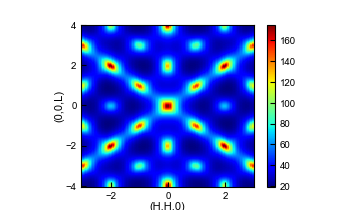

In [236]:
# Find the good T avoiding negative which cause problems for powder averaging
x = np.linspace(-3, 3, num=121, endpoint=True)-3/121.
y = np.linspace(-4, 4, num=161, endpoint=True)-4/161.
X, Y = np.meshgrid(x, y)

# For 3Tkb-2*val
# sqs = np.reshape([Sq_nnDaJexDip_fast( 2*np.pi*np.array([i,i,j]), 10, -2/11.6, 0, 2.7) for i in x for j in y], (121, 161)) 
# sqs = np.reshape([Sq_nnDaJexDip_fast( 2*np.pi*np.array([i,i,j]), 10, 2/11.6, 0, 1.3) for i in x for j in y], (121, 161)) 
#sqs = np.reshape([Sq_nnDaJexDip_fast( 2*np.pi*np.array([i,i,j]), 10,  0, 1.4/11.6, 3.3) for i in x for j in y], (121, 161))

plt.figure()
plt.pcolor(X, Y, sqs.T, cmap='jet')
plt.gca().set_aspect(0.707)
plt.xlabel('(H,H,0)',labelpad=1)
plt.ylabel('(0,0,L)',labelpad=1)
plt.colorbar()
plt.show()

CPU times: total: 422 ms
Wall time: 26.5 s


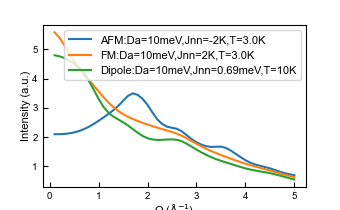

In [145]:
# Reproduce the nn FM, AFM, dipole results of Ising model from Kadowaki et al. Phys. Rev. B 65 144421 

x = np.linspace(0.1, 5, num=50, endpoint=True)

# Calculations with T min
# %time sqs1 = np.array(Parallel(n_jobs=8)(delayed(SqPowder_nnDaJexDip)(i, 10, -2/11.6, 0,    3) for i in x*aa)) # min T 2.7K
#%time sqs2 = np.array(Parallel(n_jobs=8)(delayed(SqPowder_nnDaJexDip)(i, 10,  2/11.6, 0,    3) for i in x*aa)) # min T 1.3K
#%time sqs3 = np.array(Parallel(n_jobs=8)(delayed(SqPowder_nnDaJexDip)(i, 10,  0,  1.4/11.6, 5) for i in x*aa)) # min T 3.3K

latexify()
fig = plt.figure()
plt.plot(x, (sqs1[:,0])*gdformfact(x),label='AFM:Da=10meV,Jnn=-2K,T=3.0K')
plt.plot(x, (sqs2[:,0])*gdformfact(x),label='FM:Da=10meV,Jnn=2K,T=3.0K')
plt.plot(x, (sqs3[:,0])*gdformfact(x),label='Dipole:Da=10meV,Jnn=0.69meV,T=10K')

# plt.xlim([0.25,5])
plt.legend()
plt.xlabel(r'Q $(\mathrm{\mathsf{\AA^{-1}}})$', labelpad=1)
plt.ylabel('Intensity (a.u.)', labelpad=1)
fpath = r'D:\2_Neutron_scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed/'
fig.savefig(fpath+'Reproduce_Kadowaki et al. Phys. Rev. B 65 144421_new.pdf', bbox_inches="tight")
plt.show()

## <a id='toc2_6_'></a>[3nn](#toc0_)

### <a id='toc2_6_1_'></a>[Find neighbors](#toc0_)

In [6]:
fcc = np.array([[0,1/2.,1/2.], [1/2.,0,1/2.], [1/2.,1/2.,0]])

scIdx = np.array(list(product([0,1,-1],repeat=3)))
sc = np.array([x[0]*fcc[0]+x[1]*fcc[1]+x[2]*fcc[2] for x in scIdx])

rss = np.array([rs[:,i]+sc[j] for i in range(rs.shape[1]) for j in range(len(sc))])
atomType = np.array([i for i in range(rs.shape[1]) for j in range(len(sc))], dtype=int)

def nn3(idAtom):
    dist = np.array([LA.norm(r-rs[:,idAtom]) for r in rss])
    idAtom2 = np.argsort(dist)[1:31]
    rAtom2 = rss[idAtom2] 
    
    rij   = rAtom2 - rs[:,idAtom]
    typeAtom2 = atomType[idAtom2]
    
    bondCenters = np.array([r+rs[:,idAtom] for r in rAtom2[-12:]])/2.
    bondType = np.array([0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1])
    bondType = np.hstack([bondType , [2 if np.any(np.equal(rss,center).all(1)) else 3 for center in bondCenters]])
    return rij, typeAtom2, bondType, dist[idAtom2]

print(nn3(0))

"""
BondType: 0, 1, 2, 3
Meaning:  1nn, 2nn, 3nn_a(bond center is a atom site), 3nn_b(bond center is the haxagnal center)
"""

(array([[ 0.25,  0.  ,  0.25],
       [-0.25, -0.25,  0.  ],
       [-0.25,  0.  , -0.25],
       [ 0.  , -0.25, -0.25],
       [ 0.  ,  0.25,  0.25],
       [ 0.25,  0.25,  0.  ],
       [-0.25,  0.5 ,  0.25],
       [ 0.25,  0.5 , -0.25],
       [-0.5 , -0.25,  0.25],
       [-0.25, -0.5 ,  0.25],
       [-0.5 ,  0.25, -0.25],
       [ 0.5 ,  0.25, -0.25],
       [-0.25,  0.25,  0.5 ],
       [ 0.5 , -0.25,  0.25],
       [-0.25,  0.25, -0.5 ],
       [ 0.25, -0.25,  0.5 ],
       [ 0.25, -0.5 , -0.25],
       [ 0.25, -0.25, -0.5 ],
       [ 0.5 ,  0.  , -0.5 ],
       [-0.5 ,  0.  , -0.5 ],
       [ 0.  ,  0.5 , -0.5 ],
       [ 0.  ,  0.5 ,  0.5 ],
       [ 0.  , -0.5 , -0.5 ],
       [ 0.5 ,  0.  ,  0.5 ],
       [-0.5 , -0.5 ,  0.  ],
       [-0.5 ,  0.  ,  0.5 ],
       [-0.5 ,  0.5 ,  0.  ],
       [ 0.  , -0.5 ,  0.5 ],
       [ 0.5 , -0.5 ,  0.  ],
       [ 0.5 ,  0.5 ,  0.  ]]), array([2, 1, 2, 3, 3, 1, 2, 2, 3, 2, 3, 3, 1, 3, 1, 1, 2, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0,

'\nBondType: 0, 1, 2, 3\nMeaning:  1nn, 2nn, 3nn_a(bond center is a atom site), 3nn_b(bond center is the haxagnal center)\n'

### <a id='toc2_6_2_'></a>[3nn: J1-3， Dip1-3](#toc0_)

In [7]:
def DipMat(rij):
    return np.array([1-3*rij[a]*rij[b]/np.sum(rij**2) if a==b else -3*rij[a]*rij[b]/np.sum(rij**2)
              for a in [0,1,2] for b in [0,1,2]]).reshape([3,3])

# Prepare the Matrix for Jex and Dip
# Dipolar interactoins: rij: 4by30by3(4 atoms, 30 bonds per atom)
rij, typeAtom2, bondType, DipMats = np.zeros([4,30,3]), np.zeros([4,30], dtype=int), np.zeros([4,30],dtype=int), np.zeros([4,30,3,3])
for i in [0,1,2,3]:
    rij[i,:], typeAtom2[i,:], bondType[i,:], _ = nn3(i)
    for j in range(30):
        DipMats[i,j,:,:] = DipMat(rij[i,j,:])
                
JexMats = np.zeros([4,4,3,3])

@jit(float64(float64[::1], float64, float64, float64, float64, float64, float64), fastmath=True, nopython=True, cache=True, parallel=False)#[::1] for declareing 1D continius array 
def Sq_3nnJexDip_fast(Q, Jex0, Jex1, Jex2a, Jex2b, Dip0, T):   
    
    Dip1, Dip2 = Dip0/5.196, Dip0/8. #1.732**3, 2**3
    Jexs = np.array([Jex0, Jex1, Jex2a, Jex2b])
    Dips = np.array([Dip0, Dip1, Dip2, Dip2])
    
#     phase0 = 2*np.cos(rij0nn@Q); print(rij0nn, Q, rij0nn@Q)
    # Numba only support dot(2d,1d) type 
#     phase0 = 2*np.cos(rij0nn.reshape(16,3)@Q).reshape((4,4)); #print(rij0nn, Q, (rij0nn.reshape(16,3)@Q).reshape((4,4)))
   
    HamJexDip = np.zeros((4,4,3,3))
    iMat =  np.identity(3)
    for i in range(4):
        for j in range(30):
            k, l = typeAtom2[i,j], bondType[i,j]
            HamJexDip[i,k,:,:] = HamJexDip[i,k,:,:] + (Jexs[l]*iMat - Dips[l]*DipMats[i,j,:,:])* np.cos(Q@rij[i,j,:])
            
    HamJexDip = np.transpose(HamJexDip, (0,2,1,3)).copy().reshape((12,12)).copy()
    val, vec = LA.eigh(HamJexDip) # eigh: orthorgnal vec for symmetric matirx; eig does not.
    #Fq = np.sum(vec.reshape((4,3,12)), axis=0)# good without jit
    Fq = np.transpose(np.sum(np.transpose(vec).reshape((12,4,3)), axis=1))# good for jit and without jit (numba take vec as F array)
    Fq_perp = Fq - Q.reshape((3,1))@(Q@Fq).reshape((1,12))/np.sum(Q**2)
    
    return np.sum( np.sum(Fq_perp**2, axis=0) / (3*T*kb - val) )

def SqPowder_3nnJexDip(q, Jex0, Jex1, Jex2a, Jex2b, Dip0, T): # 11ms
    return integrate.nquad(lambda th, phi: Sq_3nnJexDip_fast(np.array([q*np.sin(th)*np.cos(phi), q*np.sin(th)*np.sin(phi), q*np.cos(th)]), Jex0, Jex1, Jex2a, Jex2b, Dip0, T)*np.sin(th), 
                           [[0, np.pi/2],[0, np.pi/4]], opts={'epsrel':0.01})#opts={'epsrel':0.01}

In [8]:
Sq_3nnJexDip_fast( 2*np.pi*np.array([0,0,2]), JexGd, 0,0,0, DipGd, 5)

14.33499907023265

In [9]:
SqPowder_3nnJexDip(1, JexGd, 0,0,0, DipGd, 3.2)

(2.589927223167702, 8.160573083470259e-08)

### <a id='toc2_6_3_'></a>[3NN: J1-3, Dip1-3, Daniso](#toc0_)

In [10]:
# Prepare the Matrix for Jex and Dip
# Dipolar interactoins: rij: 4by30by3(4 atoms, 30 bonds per atom)
def DipMat(rij):
    return np.array([1-3*rij[a]*rij[b]/np.sum(rij**2) if a==b else -3*rij[a]*rij[b]/np.sum(rij**2)
              for a in [0,1,2] for b in [0,1,2]]).reshape([3,3])

rij, typeAtom2, bondType, DipMats = np.zeros([4,30,3]), np.zeros([4,30], dtype=int), np.zeros([4,30],dtype=int), np.zeros([4,30,3,3])
for i in [0,1,2,3]:
    rij[i,:], typeAtom2[i,:], bondType[i,:], _ = nn3(i)
    for j in range(30):
        DipMats[i,j,:,:] = DipMat(rij[i,j,:])
            
# Prepare anisotropy matrix
DaMats = np.empty([4,3,3])
for i in [0,1,2,3]:
    DaMats[i,:,:] = ns[i].reshape([3,1])@ns[i].reshape([1,3])
            
iMat =  np.identity(3)    
@jit(float64(float64[::1], float64, float64, float64, float64, float64, float64, float64), fastmath=True, nopython=True, cache=True, parallel=False)#[::1] for declareing 1D continius array 
def Sq_3nnDaJexDip_fast(Q, Da, Jex0, Jex1, Jex2a, Jex2b, Dip0, T):   
    
    Dip1, Dip2 = Dip0/5.196, Dip0/8. #1.732**3, 2**3
    Jexs = np.array([Jex0, Jex1, Jex2a, Jex2b])
    Dips = np.array([Dip0, Dip1, Dip2,  Dip2])
    #Dips = np.array([Dip0, Dip1, 0, 0])
    
    HamJexDip = np.zeros((4,4,3,3))
    for i in range(4):
        for j in range(30):
            k, l = typeAtom2[i,j], bondType[i,j]
            HamJexDip[i,k,:,:] = HamJexDip[i,k,:,:] + (Jexs[l]*iMat - Dips[l]*DipMats[i,j,:,:])* np.cos(Q@rij[i,j,:])
    for i in [0,1,2,3]:
        HamJexDip[i,i,:,:] = HamJexDip[i,i,:,:] + Da*(DaMats[i,:,:] - iMat)
        
    HamJexDip = np.transpose(HamJexDip, (0,2,1,3)).copy().reshape((12,12)).copy()
    val, vec = LA.eigh(HamJexDip) # eigh: orthorgnal vec for symmetric matirx; eig does not.

    #Fq = np.sum(vec.reshape((4,3,12)), axis=0)# good without jit
    Fq = np.transpose(np.sum(np.transpose(vec).reshape((12,4,3)), axis=1))# good for jit and without jit (numba take vec as F array)
    Fq_perp = Fq - Q.reshape((3,1))@(Q@Fq).reshape((1,12))/np.sum(Q**2)
    
    return np.sum( np.sum(Fq_perp**2, axis=0) / (3*T*kb - val) )

def SqPowder_3nnDaJexDip(q, Da, Jex0, Jex1, Jex2a, Jex2b, Dip0, T):
    return integrate.nquad(lambda th, phi: Sq_3nnDaJexDip_fast(np.array([q*np.sin(th)*np.cos(phi), q*np.sin(th)*np.sin(phi), q*np.cos(th)]), Da, Jex0, Jex1, Jex2a, Jex2b, Dip0, T)*np.sin(th), 
                           [[0, np.pi/2],[0, np.pi/4]], opts={'epsrel':0.01})#opts={'epsrel':0.01}

SqPowder_3nnDaJexDip_vec = np.vectorize(SqPowder_3nnDaJexDip, excluded=['q'])
# @guvectorize([(float64, float64[:], float64[:], float64[:], float64[:], float64[:], float64[:],float64[:], float64)], '(),(n),(n),(n),(n),(n),(n),(n)->(n)')
# def SqPowder_3nnDaJexDip_vec(q, Da, Jex0, Jex1, Jex2a, Jex2b, Dip0, T, out):
#     out = integrate.nquad(lambda th, phi: Sq_3nnDaJexDip_fast(np.array([q*np.sin(th)*np.cos(phi), q*np.sin(th)*np.sin(phi), q*np.cos(th)]), Da, Jex0, Jex1, Jex2a, Jex2b, Dip0, T)*np.sin(th), 
#                            [[0, np.pi/2],[0, np.pi/4]], opts={'epsrel':0.01})
    
# @vectorize([float64(float64, float64, float64, float64, float64, float64, float64,float64)])
# def SqPowder_3nnDaJexDip_vec(q, Da, Jex0, Jex1, Jex2a, Jex2b, Dip0, T):
#     return integrate.nquad(lambda th, phi: Sq_3nnDaJexDip_fast(np.array([q*np.sin(th)*np.cos(phi), q*np.sin(th)*np.sin(phi), q*np.cos(th)]), Da, Jex0, Jex1, Jex2a, Jex2b, Dip0, T)*np.sin(th), 
#                            [[0, np.pi/2],[0, np.pi/4]], opts={'epsrel':0.01})#opts={'epsrel':0.01}

In [11]:
# Test: at a Q point for two sets of parameters.
SqPowder_3nnDaJexDip_vec(aa, [0,0], [JexGd, JexGd], [0,0],[0,0],[0,0], [0.066,0.066], [30,30] )

(array([0.85341612, 0.85341612]), array([4.69022689e-09, 4.69022689e-09]))

In [12]:
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.5g" % x))

#Sq_3nnDaJexDip_fast(np.array([0, 0, 0.5*np.pi]), 0, -1.,0,0,0,0,1)
%time Sq_3nnDaJexDip_fast(np.array([0, 0, 4*np.pi]), 0, -0.166,0,0,0, 0.01, 2)

CPU times: total: 0 ns
Wall time: 0 ns


47.44494530761709

In [13]:
# %time SqPowder_3nnDaJexDip(1, -10, 0,0,0,0, 0.069, 9)
%time SqPowder_3nnDaJexDip(aa, 0, JexGd,0,0,0, 0.066, 30)

CPU times: total: 15.6 ms
Wall time: 20.8 ms


(0.8534161196945914, 4.6902268894149375e-09)

# <a id='toc3_'></a>[HHL plane and Powder](#toc0_)

## <a id='toc3_1_'></a>[HHL plane](#toc0_)

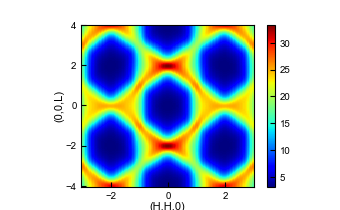

In [14]:
x = np.linspace(-3, 3, num=121, endpoint=True)-3/121.
y = np.linspace(-4, 4, num=161, endpoint=True)-4/161.
X, Y = np.meshgrid(x, y)
#sqs = np.reshape([SqFast( 2*np.pi*np.array([i,i,j]), -0.3, 4.65 ) for i in x for j in y], (121, 161))
#sqs = np.reshape([Sq_nnJexDip_fast( 2*np.pi*np.array([i,i,j]), JexGd, DipGd, 7.3) for i in x for j in y], (121, 161))
#sqs = np.reshape([Sq_nnDaJexDip_fast( 2*np.pi*np.array([i,i,j]), 0, -0.3, 0*0.069, 4.8) for i in x for j in y], (121, 161))

#sqs = np.reshape([Sq_3nnDaJexDip_fast( 2*np.pi*np.array([i,i,j]), 10, 2/11.6,0,0,0,0, 1.3) for i in x for j in y], (121, 161))
#sqs = np.reshape([Sq_3nnDaJexDip_fast( 2*np.pi*np.array([i,i,j]), 10, 0, 0, 0,0, 1.4/11.6, 5) for i in x for j in y], (121, 161)) # dipolar spin ice

sqs = np.reshape([Sq_3nnDaJexDip_fast( 2*np.pi*np.array([i,i,j]), DanGd, JexGd, 0, 0,0, DipGd, 3.4) for i in x for j in y], (121, 161)) # dipolar spin ice

plt.figure()
plt.pcolor(X, Y , sqs.T, cmap='jet')
plt.gca().set_aspect(0.707)
plt.xlabel('(H,H,0)',labelpad=1)
plt.ylabel('(0,0,L)',labelpad=1)
plt.colorbar()
plt.show()

## <a id='toc3_2_'></a>[Reproduce P. H. Conlon and J. T. Chalker PRB 81, 224413(2010)](#toc0_)

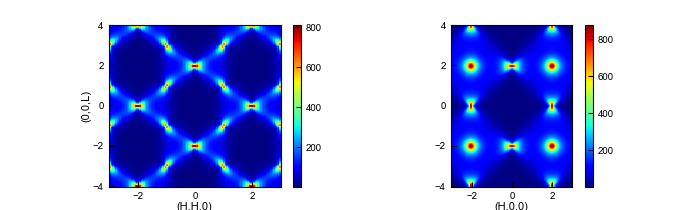

In [15]:
x = np.linspace(-3, 3, num=121, endpoint=True)-3/121.
y = np.linspace(-4, 4, num=161, endpoint=True)-4/161.
X, Y = np.meshgrid(x, y)

# Reproduce the figures from P. H. Conlon and J. T. Chalker PRB 81, 224413(2010)
# (T is 0.1J1 in the paper, too low for MF here!
# Here T>=0.71Jex*11.6 K!
# T = c*|Jex| = -c*Jex
J1, J2, J3a, J3b, T = JexGd*np.array([1,  0,      0,     0, -0.72*11.6]) # Figure 3 (left)
J1, J2, J3a, J3b, T = JexGd*np.array([1,  0,     0.025, 0.025, -0.72*11.6]) # Figure 3 (right)
J1, J2, J3a, J3b, T = JexGd*np.array([1, -0.025, 0,     0,     -0.75*11.6]) # preproduced Figure 6
J1, J2, J3a, J3b, T = JexGd*np.array([1,  0.025, 0,     0,     -0.71*11.6]) # Figure 7
sqs_hhl = np.reshape([Sq_3nnJexDip_fast( 2*np.pi*np.array([i,i,j]), J1,J2,J3a,J3b,0, T) for i in x for j in y], (121, 161))
sqs_hl0 = np.reshape([Sq_3nnJexDip_fast( 2*np.pi*np.array([i,j,0]), J1,J2,J3a,J3b,0, T) for i in x for j in y], (121, 161))

# test
#J1, J2, J3a, J3b, T = JexGd*np.array([1,  0.01, 0,     0,     -0.71*11.6]) # Figure 7
#sqs_hhl = np.reshape([Sq_3nnJexDip_fast( 2*np.pi*np.array([i,i,j]), J1,J2,J3a,J3b,DipGd, 2.38) for i in x for j in y], (121, 161))
#sqs_hl0 = np.reshape([Sq_3nnJexDip_fast( 2*np.pi*np.array([i,j,0]), J1,J2,J3a,J3b,DipGd, 2.38) for i in x for j in y], (121, 161))

latexify(columns=2)
fig, axs = plt.subplots(nrows=1,ncols=2)
p1 = axs[0].pcolor(X, Y, sqs_hhl.T, cmap='jet', shading='auto')
p2 = axs[1].pcolor(X, Y, sqs_hl0.T, cmap='jet', shading='auto')
axs[0].set_aspect(0.707)
axs[1].set_aspect(1)
axs[0].set_xlabel('(H,H,0)',labelpad=1)
axs[1].set_xlabel('(H,0,0)',labelpad=1)
axs[0].set_ylabel('(0,0,L)',labelpad=1)  
fig.colorbar(p1, ax=axs[0])
fig.colorbar(p2, ax=axs[1])
plt.show()

## <a id='toc3_3_'></a>[Powder](#toc0_)

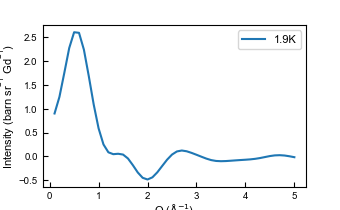

In [18]:
# Reproduce the result in PRL CdEr2S4 by Shang Gao (note: they used dipolar interaction up to 5th u.c.!!!)

x = np.linspace(0.1, 5, num=50, endpoint=True)

sqs1 = np.array(Parallel(n_jobs=8)(delayed(SqPowder_3nnDaJexDip)(i, 10, 0,0,0,0, 0.69/11.6, 1.9) for i in x*aa))
# %time sqs10 = np.array(Parallel(n_jobs=8)(delayed(SqPowder_3nnDaJexDip)(i, -100, 0,0,0,0, 0.069, 1.9) for i in x*aa))
# %time sqs2 = np.array(Parallel(n_jobs=8)(delayed(SqPowder_3nnDaJexDip)(i, -10, 0,0,0,0, 0.069, 2.3) for i in x*aa))
# %time sqs3 = np.array(Parallel(n_jobs=8)(delayed(SqPowder_3nnDaJexDip)(i, -10, 0,0,0,0, 0.069, 3.8) for i in x*aa))
# %time sqs4 = np.array(Parallel(n_jobs=8)(delayed(SqPowder_3nnDaJexDip)(i, -100, 0,0,0,0, 0.069, 15.8) for i in x*aa))
# if set Da=-10 and T=15.8 as in the paper, negative intensity. Why?

latexify()
fig = plt.figure()
plt.plot(x, (sqs1[:,0]-6)*gdformfact(x),label='1.9K')
# plt.plot(x, (sqs10[:,0]-6)*gdformfact(x),label='1.9K_with_aniso100')
# plt.plot(x, (sqs2[:,0]-0)*gdformfact(x),label='2.3K')
# plt.plot(x, (sqs3[:,0]-0)*gdformfact(x),label='3.8K')
# plt.plot(x, (sqs4[:,0]-0),label='15.8K')
#plt.xlim([0.25,3])
plt.legend()
plt.xlabel(r'Q $(\mathrm{\mathsf{\AA^{-1}}})$', labelpad=1)
plt.ylabel('Intensity (barn sr$^{-1}$ Gd$^{-1}$)', labelpad=1)

plt.show()

In [ ]:
x = np.linspace(0.1, 5, num=50, endpoint=True)

#%time sqs = np.array(Parallel(n_jobs=8)(delayed(SqPowder_3nnJexDip)(i, JexGd,0.01*JexGd,0,0, DipGd, 2.5) for i in x*aa))
#%time sqs1 = np.array(Parallel(n_jobs=8)(delayed(SqPowder_nnDaJexDip)(i, -10, 0, 0.069, 1.9) for i in x*aa))

# latexify()
# plt.figure()
# plt.plot(x, sqs1[:,0]gdformfact(x))
# plt.xlim([0.25,3])
# plt.legend()
# plt.xlabel(r'Q $(\mathrm{\mathsf{\AA^{-1}}})$', labelpad=1)
# plt.ylabel('Intensity (barn sr$^{-1}$ Gd$^{-1}$)', labelpad=1)

# plt.show()

In [19]:
# Cmapare with/without easy-plane anisotropy
x = np.linspace(0.1, 5, num=50, endpoint=True)

%time sqs_Da = np.array(Parallel(n_jobs=8)(delayed(SqPowder_3nnDaJexDip)(i, -0.5*JexGd, JexGd,0,0,0, DipGd, 2.05) for i in x*aa))
%time sqs_Da0 = np.array(Parallel(n_jobs=8)(delayed(SqPowder_3nnDaJexDip)(i, 0, JexGd,0,0,0, DipGd, 2.37) for i in x*aa))

latexify()
plt.figure()
plt.plot(x, sqs_Da[:,0],label='With aniso')
plt.plot(x, sqs_Da0[:,0],label='Without')
plt.legend()
plt.xlabel(r'Q $(\mathrm{\mathsf{\AA^{-1}}})$', labelpad=1)
plt.ylabel('Intensity (barn sr$^{-1}$ Gd$^{-1}$)', labelpad=1)

plt.show()

# <a id='toc4_'></a>[Calc and plot SqPowder](#toc0_)

In [22]:
x = np.linspace(0.1, 5, num=50, endpoint=True)*aa
#%timeit 
import time
start_time = time.time()
sqs_py = [SqPowder_nnJexDip(i, -1,0, 7.8) for i in x]
time.time()-start_time

15.839060544967651

## <a id='toc4_1_'></a>[Compare with matlab and julia](#toc0_)
Python with @njit 180s, Matlab 130s, Julia 120s

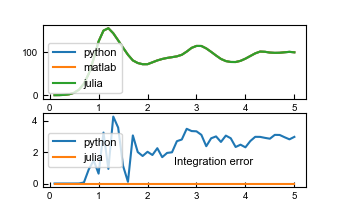

In [24]:
dat_matlab = np.genfromtxt("D:/2_Neutron_scattering/2_D7_ILL_Gd2Hf2O7_Feb2020/MF_Sq_matlab.txt", skip_header=1,delimiter=',')
dat_julia = np.genfromtxt("D:/2_Neutron_scattering/2_D7_ILL_Gd2Hf2O7_Feb2020/MF_Sq_julia.txt")

fig, axs = plt.subplots(nrows=2, ncols=1)
axs[0].plot(x/aa, np.array(sqs_py)[:,0]/2.0, label='python')
axs[0].plot(dat_matlab[:,0], dat_matlab[:,1],label='matlab')
axs[0].plot(dat_julia[:,0], dat_julia[:,1], label='julia')
axs[0].legend()

axs[1].plot(x/aa, np.array(sqs_py)[:,1], label='python')
axs[1].plot(dat_julia[:,0], dat_julia[:,2], label='julia')
axs[1].legend()
axs[1].text(0.5,0.3,'Integration error',transform=axs[1].transAxes)
plt.show()

In [ ]:
#np.savetxt(r"D:\2_Neutron_scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\MF_Sq_python.txt", np.array([x/aa, sqs.T]))

In [ ]:
np.all(np.array([1,1,2])%2==1)

# <a id='toc5_'></a>[Load data and fitting](#toc0_)
mf_fit_all.pdf is in the 'SpinVert_fit_diff_plot.ipynb'

## <a id='toc5_1_'></a>[Load 35mK data](#toc0_)

[[ 3.4333766   1.05413602  0.11497789]
 [ 3.913817    0.82902618  0.1022179 ]
 [ 4.35152323  1.1881608   0.07909196]
 [ 4.90512502  1.23148411  0.06403342]
 [ 5.35984192  1.45391093  0.06619035]
 [ 5.80759344  1.55198679  0.06644272]
 [ 6.35892892  1.81193296  0.07094867]
 [ 6.81084981  2.0464775   0.07241644]
 [ 7.25645466  2.53062982  0.07094937]
 [ 7.80484257  3.13589105  0.07457834]
 [ 8.25341978  4.04772169  0.08046585]
 [ 8.69631758  5.18105303  0.08249631]
 [ 9.2410717   6.13506859  0.10388483]
 [ 9.68575416  7.71508432  0.11323908]
 [10.12539072  9.08070182  0.11714014]
 [10.66583538 10.29794732  0.12690961]
 [11.10607633 10.43224916  0.11397019]
 [11.54190741 10.98317736  0.12320329]
 [12.07736445 10.34961466  0.12658526]
 [12.51263018  9.82765657  0.12886392]
 [12.94410716  9.22174257  0.12023088]
 [13.47390709  8.32938468  0.11552778]
 [13.9036707   7.99123577  0.11385778]
 [14.33025303  7.99174917  0.10897836]
 [14.85373135  7.23733404  0.10643871]
 [15.2774684   7.24539099

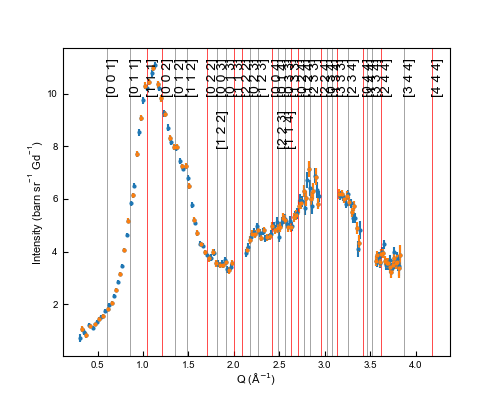

In [11]:
# Load and reduce data
data_path = "D:/2_Neutron_scattering/2_D7_ILL_Gd2Hf2O7_Feb2020/ILLData_201_d7_exp_5-32-883_processed/35mK_data.txt"
data = np.genfromtxt(data_path)

data[:,1] = data[:,1]/gdformfact(data[:,0]) # remove form fatctor
data[:,2] = data[:,2]/gdformfact(data[:,0])

# Get less nb of point for fitting
data_part = data[1::2,:].copy()
data_part[:,0] = data_part[:,0]*aa # convert to reciprocal lattice unit
print(data_part, data_part.shape)

# Plot Bragg positions
hkls = np.array(list(combinations_with_replacement([0,1,2,3,4],r=3)))
hkls_q = LA.norm(hkls, axis=1)*2*np.pi/aa
plt.figure(figsize=[5,4])
plt.errorbar(data[:,0], data[:,1], yerr = data[:,2], fmt='o',ms=2)
plt.errorbar(data_part[:,0]/aa, data_part[:,1], yerr = data_part[:,2], fmt='o',ms=2)
for i in range(len(hkls_q))[1:]:
    color = 'gray'
    if np.all(hkls[i]%2==0) | np.all(hkls[i]%2==1):
        color = 'red' # all even/odd Bragg peaks
    if hkls_q[i] not in hkls_q[0:i]:
        plt.axvline(hkls_q[i],0,1,color=color,lw=0.5)
        plt.text(hkls_q[i], 10, str(hkls[i]), size=10, rotation=90)
    else:
        plt.text(hkls_q[i], 8, str(hkls[i]), size=10, rotation=90)
plt.xlabel(r'Q $(\mathrm{\mathsf{\AA^{-1}}})$', labelpad=1)
plt.ylabel('Intensity (barn sr$^{-1}$ Gd$^{-1}$)', labelpad=1)
plt.show()

## <a id='toc5_2_'></a>[Other data (update `data` for fit)](#toc0_)

In [47]:
fpath = "D:/2_Neutron_scattering/2_D7_ILL_Gd2Hf2O7_Feb2020/ILLData_201_d7_exp_5-32-883_processed"
fnames = ['1K_data.txt','2K_data.txt','4K_data.txt','8K_data.txt','30K_data.txt']

In [48]:
x0 = [2.6, 3, 5, 6, 20] # T
fit = [DanGd, -1.948e-01, 1.891e-02, 1.320e-02, 2.325e-03, DipGd, 2.699]

for idx, fname in enumerate([fnames[4]]):
    print(fname)
    fpath_name = os.path.join(fpath,fname)
    print(fpath_name)
    
    data = np.genfromtxt(fpath_name)
    data[:,1] = data[:,1]/gdformfact(data[:,0]) # remove form fatctor
    data[:,2] = data[:,2]/gdformfact(data[:,0])

    # Get less nb of point for fitting
    data_part = data[1::2,:].copy()
    data_part[:,0] = data_part[:,0]*aa # convert to reciprocal lattice unit
    print(data_part, data_part.shape)

    # Fit
    rem_Target = []
    parSqs.refresh()

    x_start = [x0[idx]]

    with Parallel(n_jobs=8) as parallel:
        res = minimize(lambda x: minTarget_opt_scale(fit[0],fit[1],fit[2],fit[3], fit[4], fit[5], x[0], parallel), 
                    x_start,
                    bounds=[(1,20)],
                    method='Nelder-Mead')

    print(res)
    # np.savetxt(os.path.join(fpath, 'rem_Target_fit_only_T'+fname), rem_Target, fmt="%s")

30K_data.txt
D:/2_Neutron_scattering/2_D7_ILL_Gd2Hf2O7_Feb2020/ILLData_201_d7_exp_5-32-883_processed\30K_data.txt
[[ 3.3252315   4.00842854  0.26977184]
 [ 3.74506853  4.00938441  0.23204068]
 [ 4.17713873  4.08106626  0.19381016]
 [ 4.61592171  4.49673959  0.20059325]
 [ 5.00093248  4.75678275  0.16187325]
 [ 5.38971868  4.72977442  0.18239674]
 [ 5.80519385  4.96201637  0.16319492]
 [ 6.22394886  4.31557379  0.17279403]
 [ 6.64416556  4.87017746  0.1596967 ]
 [ 7.0842875   5.17669658  0.17006777]
 [ 7.51703401  5.08262019  0.17674713]
 [ 7.89960551  5.01480674  0.16250953]
 [ 8.28409991  4.90666767  0.17750788]
 [ 8.69394774  5.080731    0.15511541]
 [ 9.1078794   5.28465295  0.18115383]
 [ 9.52060785  5.63492266  0.16437311]
 [ 9.95628085  5.33589198  0.18193707]
 [10.38089256  5.52869077  0.1986174 ]
 [10.75908146  5.42962206  0.18284144]
 [11.13737946  5.6309106   0.18161128]
 [11.53957911  5.89157569  0.17903686]
 [11.94662133  5.65346852  0.18613428]
 [12.3498723   5.77516479  0

D:/2_Neutron_scattering/2_D7_ILL_Gd2Hf2O7_Feb2020/ILLData_201_d7_exp_5-32-883_processed\35mK_data.txt


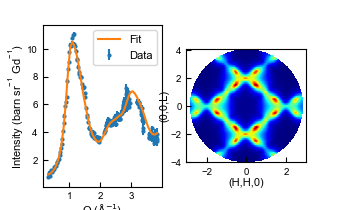

D:/2_Neutron_scattering/2_D7_ILL_Gd2Hf2O7_Feb2020/ILLData_201_d7_exp_5-32-883_processed\1K_data.txt


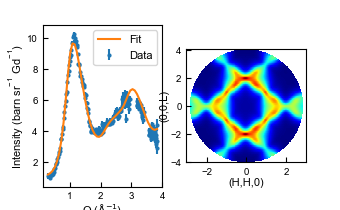

D:/2_Neutron_scattering/2_D7_ILL_Gd2Hf2O7_Feb2020/ILLData_201_d7_exp_5-32-883_processed\2K_data.txt


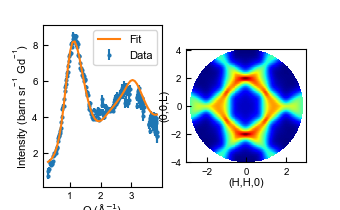

D:/2_Neutron_scattering/2_D7_ILL_Gd2Hf2O7_Feb2020/ILLData_201_d7_exp_5-32-883_processed\4K_data.txt


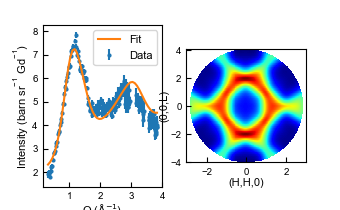

D:/2_Neutron_scattering/2_D7_ILL_Gd2Hf2O7_Feb2020/ILLData_201_d7_exp_5-32-883_processed\8K_data.txt


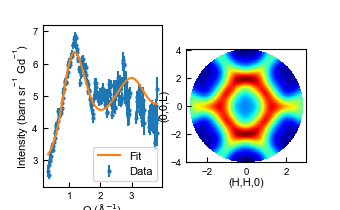

D:/2_Neutron_scattering/2_D7_ILL_Gd2Hf2O7_Feb2020/ILLData_201_d7_exp_5-32-883_processed\30K_data.txt


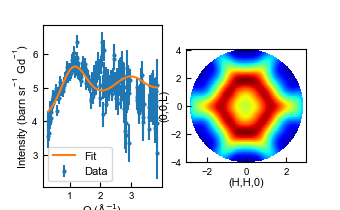

In [49]:
# Plot all
fit = [DanGd, -1.948e-01, 1.891e-02, 1.320e-02, 2.325e-03, DipGd, 2.699]

scales = [0.1861, 0.2445, 0.3403, 0.6129, 1.1311, 3.1287]
Ts = [2.699, 2.787, 3.042, 3.913, 6.015, 15]

for idx, fname in enumerate(['35mK_data.txt'] + fnames):
    
    fpath_name = os.path.join(fpath,fname)
    print(fpath_name)

    data = np.genfromtxt(fpath_name)
    data[:,1] = data[:,1]/gdformfact(data[:,0]) # remove form fatctor
    data[:,2] = data[:,2]/gdformfact(data[:,0])

    # Get less nb of point for fitting
    data_part = data[1::2,:].copy()
    data_part[:,0] = data_part[:,0]*aa # convert to reciprocal lattice unit

    x_long, fit_sqs = plot_res(scale=scales[idx], Da=fit[0], Jex0=fit[1],Jex1=fit[2],Jex2a=fit[3],Jex2b=fit[4], Dip=fit[5], T=Ts[idx], plot_fit=True)
    np.savetxt(fpath_name.replace('.txt', '_MF_fit.txt'), np.vstack([x_long, fit_sqs]).T)

In [28]:
# Fit only T
# Internal fit scale
rem_Target = []
parSqs.refresh()

fit = [DanGd, -1.948e-01, 1.891e-02, 1.320e-02, 2.325e-03, DipGd, 2.699]
x_start = [2.699]

tic = time.time()
with Parallel(n_jobs=8) as parallel:
    res = minimize(lambda x: minTarget_opt_scale(fit[0],fit[1],fit[2],fit[3], fit[4], fit[5], x[0], parallel), 
                   x_start,
                   bounds=[(1,10)],
                   method='Nelder-Mead')# method = 'Nelder-Mead')
toc = time.time()-tic

print(res)
fpath = r'D:\2_Neutron_scattering\2_D7_ILL_Gd2Hf2O7_Feb2020/'
np.savetxt(os.path.join(fpath, 'rem_Target_fit_only_T_1K.txt'), rem_Target, fmt="%s")

"""
Chi^2:   497.2369, Scale: 0.2445, Opt_scale Success: False
Parameters are:  0.0033620689655172414 -0.1948 0.01891 0.0132 0.002325 0.066 2.786539587402343
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 497.23686353031997
             x: [ 2.787e+00]
           nit: 13
          nfev: 26
 final_simplex: (array([[ 2.787e+00],
                       [ 2.787e+00]]), array([ 4.972e+02,  4.972e+02]))
"""

24 Nov 2023 13:05:21,  Function call count:   1,  fit parameters are 1.000000 0.003362 -0.194800 0.018910 0.013200 0.002325 0.066000 2.699000
run time(s):  0.0
Chi^2:  1187.3202, Scale: 0.1828, Opt_scale Success: True
Parameters are:  0.0033620689655172414 -0.1948 0.01891 0.0132 0.002325 0.066 2.699
24 Nov 2023 13:05:33,  Function call count:   2,  fit parameters are 1.000000 0.003362 -0.194800 0.018910 0.013200 0.002325 0.066000 2.833950
run time(s):  0.0
Chi^2:   578.9629, Scale: 0.2706, Opt_scale Success: True
Parameters are:  0.0033620689655172414 -0.1948 0.01891 0.0132 0.002325 0.066 2.8339499999999997
24 Nov 2023 13:05:41,  Function call count:   3,  fit parameters are 1.000000 0.003362 -0.194800 0.018910 0.013200 0.002325 0.066000 2.968900
run time(s):  0.0
Chi^2:  1248.3561, Scale: 0.3331, Opt_scale Success: True
Parameters are:  0.0033620689655172414 -0.1948 0.01891 0.0132 0.002325 0.066 2.9688999999999997
24 Nov 2023 13:05:48,  Function call count:   4,  fit parameters are 1.

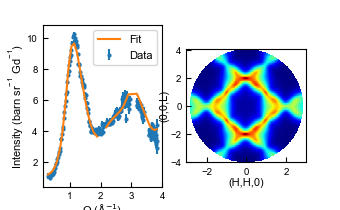

In [27]:
fit = [DanGd, -1.948e-01, 1.891e-02, 1.320e-02, 2.325e-03, DipGd, 2.699, 0.2445]
fit[6] = 2.787
plot_res(scale=fit[7], Da=fit[0], Jex0=fit[1],Jex1=fit[2],Jex2a=fit[3],Jex2b=fit[4], Dip=fit[5], T=fit[6], plot_fit=True)

# sqs = np.reshape([Sq_3nnDaJexDip_fast( 2*np.pi*np.array([i,i,j]), *fit[0:7]) for i in x for j in y], (121, 161))


# <a id='toc6_'></a>[Fit 3nn with Da](#toc0_)

### <a id='toc6_1_1_'></a>[Define fit function](#toc0_)

In [ ]:
# Memorize the timeing consuming powder average result if only scale is changed while fitting
# https://www.python-course.eu/python3_memoization.php
class Memoize:
    def __init__(self, fn):
        self.fn = fn
        self.memo = {}
        self.count = 0
        
    def __call__(self, *args):
        self.count += 1
        call_time = time.localtime()
        
        print(time.strftime("%d %b %Y %H:%M:%S, ", call_time), 'Function call count: %3d, ' % self.count,
              'fit parameters are '+' '.join('{:1.6f}'.format(k) for k in args[0:8]) )
        
        if args[1:8] not in self.memo:
            self.memo[args[1:8]] = self.fn(*args)/args[0]
            
        print('run time(s): ', time.mktime(time.localtime())-time.mktime(call_time))
        
        return args[0]*self.memo[args[1:8]]
    
    def refresh(self):
        self.memo = {}
        self.count = 0

class Memoize:
    def __init__(self, fn):
        self.fn = fn
        self.memo = {}
        self.count = 0
        
    def __call__(self, *args):
        self.count += 1
        call_time = time.localtime()
        
        print(time.strftime("%d %b %Y %H:%M:%S, ", call_time), 'Function call count: %3d, ' % self.count, 
              'fit parameters are '+' '.join('{:1.6f}'.format(k) for k in args[0:8]) )
        print('run time(s): ', time.mktime(time.localtime())-time.mktime(call_time))
        
        return self.fn(*args)
    
    def refresh(self):
        self.memo = {}
        self.count = 0
        
@Memoize
def parSqs(scale,Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T, parallel):
    return scale*np.array(parallel(delayed(SqPowder_3nnDaJexDip)(q, Da, Jex0, Jex1,Jex2a,Jex2b, Dip, T) for q in data_part[:,0]))[:,0]

# Q points for testing if the set parameters gives negative intensity
x = np.linspace(0.1, 3, num=30, endpoint=True)
y = np.linspace(0.1, 4, num=40, endpoint=True)
hhl = np.array([2*np.pi*np.array([i,i,j]) for i in x for j in y])
large_return_for_improper_pars = 10000*np.sum( (data_part[:,1]/data_part[:,2])**2)
    
rem_Target = []
def minTarget_opt_scale(Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T, parallel):
    #print(time.strftime("%a, %d %b %Y %H:%M:%S, ", time.gmtime()), 'fit parameters are %1.4f, %1.4f, %1.4f' % (scale, Jex, T))
    # Do not calculate powder average for improper parameters while fitting: if contains negative intensity, wrong and timing consuming
    if np.any(np.array(parallel(delayed(Sq_3nnDaJexDip_fast)(q, Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T) for q in hhl)) <0):
        
        print(time.strftime("%d %b %Y %H:%M:%S, ", time.localtime()), 'Negtive intensity, Powder function not called',
              'fit parameters are '+' '.join('{:1.6f}'.format(k) for k in [Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T]))
        
        rem_Target.append(['Negative Int.', Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T]+['','']) # appending two spaces for making same length with below
        
        return large_return_for_improper_pars
    else:
        sqs = parSqs(1.0, Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T, parallel)
        res = minimize(lambda scale: np.sum( ((scale*sqs-data_part[:,1])/data_part[:,2])**2 ), [0.16], bounds=[(0,np.inf)]) # reduced by errorbar
        
        print('Chi^2: %10.4f, Scale: %1.4f, Opt_scale Success: %s' % (res.fun, res.x[0], res.success))
        print('Parameters are: ', Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T)
        
        rem_Target.append([res.fun, res.x[0], res.success] + [Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T])
        
        return res.fun
    
minTarget_opt_scale_vec = np.vectorize(minTarget_opt_scale,  excluded=['parallel'])

def plot_res(scale=1, Da=0, Jex0=-0.166,Jex1=0,Jex2a=0,Jex2b=0, Dip=0.066, T=3., plot_fit=True):
    fig, axs = plt.subplots(ncols=2,nrows=1)
    axs[0].errorbar(data[:,0], data[:,1], yerr = data[:,2],fmt='o',ms=2,label='Data')
    
    if plot_fit:
        xmin, xmax = np.min(data[:,0]), np.max(data[:,0])
        x_long = np.linspace(xmin, xmax, num=50, endpoint=True)
        sqs_fit = np.array(Parallel(n_jobs=8)(delayed(SqPowder_3nnDaJexDip)(q, Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T) \
                                                    for q in x_long*aa))
        #x, y = data[::5,0], scale * sqs_fit[:,0]
        x, y = x_long, scale * sqs_fit[:,0]
        #y2 = np.ma.masked_where( ((x>1.978)&(x<2.11)) | ((x>2.93)&(x<3.17)) | ((x>3.5)&(x<3.57)), y) 
        axs[0].plot(x,y, label='Fit', zorder=10)
        
    axs[0].set_xlabel(r'Q $(\mathrm{\mathsf{\AA^{-1}}})$', labelpad=1)
    axs[0].set_ylabel('Intensity (barn sr$^{-1}$ Gd$^{-1}$)', labelpad=1)
    axs[0].legend()
    #plt.savefig(data_path.replace('.txt', '_fit_3nn.pdf'),bbox_inches="tight",pad_inches=0.01)

    x = np.linspace(-3, 3, num=121, endpoint=True)
    y = np.linspace(-4, 4, num=161, endpoint=True)
    X, Y = np.meshgrid(x, y)
    sqs_hhl = np.reshape([Sq_3nnDaJexDip_fast( 2*np.pi*np.array([i,i,j]), Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T) \
                          for i in x for j in y], (121, 161))
    rad = np.sqrt(2*X**2 + Y**2)
    Zm = np.ma.masked_where((rad>4)|(rad<0.01),sqs_hhl.T*gdformfact(rad*2*np.pi/aa))# mask Nan values then plot in white color

    axs[1].pcolor(X, Y , Zm, cmap='jet')
    axs[1].set_aspect(0.707)
    axs[1].set_xlabel('(H,H,0)',labelpad=1)
    axs[1].set_ylabel('(0,0,L)',labelpad=1)  
    #plt.savefig(data_path.replace('.txt', 'hhl_fitted_3nn.pdf'),bbox_inches="tight",pad_inches=0.01)
    plt.show()
    
    return x_long, scale * sqs_fit[:,0] * gdformfact(x_long)

In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Try using PSO. Error: pso needs vectorized inputing
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Call instance of GlobalBestPSO
optimizer = pso.single.GlobalBestPSO(n_particles=30, dimensions=4, options=options, bounds=[(JexGd,-0.3, -0.06, 0.1), (-JexGd,0,0.06,5)])
#optimizer = ps.single.GlobalBestPSO(n_particles=15, dimensions=3, options=options, bounds=[(JexGd,-0.3, 0.1), (-JexGd,0,5)])

# Internal fit scale
tic = time.time()
with Parallel(n_jobs=8) as parallel:
    res = optimizer.optimize(lambda x: minTarget_opt_scale_vec(x[:,0],x[:,1],x[:,2], 0,0, DipGd, x[:,3], parallel), iters=50)
toc = time.time()-tic
print(toc/3600,'hours running')

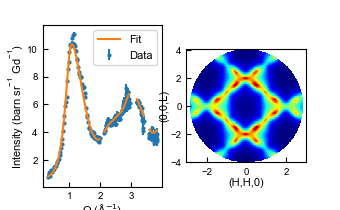

In [16]:
#-1.35483498e-01 -2.80970119e-01  2.43169650e-03  3.85548687e+00
plot_res(scale=0.25, Da=-0.1355, Jex0=-0.281, Jex1=0.00243, Jex2a=0, Jex2b=0, Dip=0.066, T=3.855)

In [ ]:
0.084/11.6
-9.6*3/6/11.6/2
print(-0.117/11.6*56/4,-0.117/11.6*49/4,-7.3*3/6/11.6/2,(0.29-0.066)*11.6*4)

In [ ]:
from pyswarms.utils.plotters import plot_cost_history, plot_contour, plot_surface
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()

## <a id='toc6_2_'></a>[Fit with fixed Da and Dip](#toc0_)

### <a id='toc6_2_1_'></a>[Plot](#toc0_)

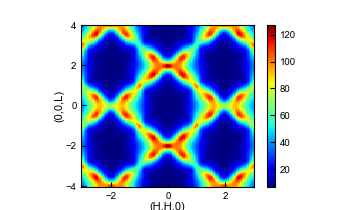

In [68]:
# Plot 2D for fit

## Parameter:   j0, j1, j2a,j2b, T, scale, chi2
xxs = []
# Old fit all?
xxs.append(np.array([-0.1626426,  0.01837789,  0.01,  0.00479971,  2.41644971, 0.1612, 000])) #0 Fit with Da=0

# Fit 1 parametes with JexGd and DipGd as start
xxs.append(np.array([-2.561e-01,  0,0,0,           3.098e+00, 0.2168, 503])) #1 Fit j0, T with fixed Da, dip and j1=j2a=j2b=0
xx = np.array([-2.954e-01, 0,0,0, 3.413e+00, 0.2308, 541]) # Fit with aa=10.5

# Fit 2 prarmeters with the result of fitting with one parameters as start
xxs.append(np.array([-2.432e-01, 3.865e-03, 0, 0,  2.987e+00, 0.2016, 431])) #2 Fit j0, j1, T with fixed Da, dip and j2a=j2b=0
xxs.append(np.array([-2.663e-01, 0, 0, -1.337e-03, 3.181e+00, 0.2209, 489])) #3 Fit j0, j2b, T with fixed Da, dip and j1=j2a=0
xxs.append(np.array([-2.594e-01, 0, -3.787e-03,0,  3.086e+00, 0.2043, 443])) #4 Fit j0, j2a, T with fixed Da, dip and j1=j2b=0

# Fit 3 parameters 
## with the result of fitting with one parameters as start
xxs.append(np.array([-2.059e-01, 6.272e-03,  0, 2.880e-03, 2.677, 0.1785, 406.19])) #5 Fit j0, j1, j2b, T with fixed Da, dip and j2a=0
xxs.append(np.array([-2.497e-01, 2.979e-02,  2.619e-02, 0, 3.255, 0.2214, 410.37])) #6 Fit j0, j1, j2a, T with fixed Da, dip and j2b=0

## with the result of fitting with one parameters as start
#xx = np.array([]) # Fit j0, j1, j2b, T with fixed Da, dip and j2a=0
#xx = np.array([]) # Fit j0, j1, j2a, T with fixed Da, dip and j2b=0

# Fit 4 parameters
## with the result of fitting with one parameters as start
xxs.append(np.array([-2.186e-01, 2.987e-02, 2.585e-02, 6.589e-04, 2.999, 0.2087, 391])) #7 Fit j0, j1, j2a, j2b, T with fixed Da, dip
xxs.append(np.array([-1.948e-01, 1.891e-02, 1.320e-02, 2.325e-03, 2.699, 0.1861, 388])) #8 different x_start
             
#Random fitting

########### Why are the negative J2 not tested????
# Others with x_start = [-0.1626426,   0.01837789,  0.01,  0.00479971,  2.41644971]
#xx = np.array([-1.963e-01,  6.508e-03,  0,      3.122e-03,  2.599e+00, 0.1739]) # Fit j0,j1,j2b,T with fixed Da, dipole, j2a=0
#xx = np.array([-1.948e-01,  1.891e-02,  1.320e-02,  2.325e-03,  2.699e+00, 0.1862]) # Fit j0,j1,j2a,j2b,T with fixed Da, dip

xx = xxs[0]

x = np.linspace(-3, 3, num=121, endpoint=True)-3/121.
y = np.linspace(-4, 4, num=161, endpoint=True)-4/161.
X, Y = np.meshgrid(x, y)

sqs = np.reshape([Sq_3nnDaJexDip_fast( 2*np.pi*np.array([i,i,j]), DanGd, xx[0], xx[1], xx[2], xx[3],DipGd, xx[4]) for i in x for j in y], (121, 161))

plt.figure()
plt.pcolor(X, Y , sqs.T, cmap='jet')
plt.gca().set_aspect(0.707)
plt.xlabel('(H,H,0)',labelpad=1)
plt.ylabel('(0,0,L)',labelpad=1)
plt.colorbar()
plt.show()

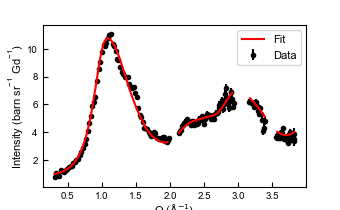

In [69]:
# Plot fit and data
plt.figure()
plt.errorbar(data[:,0], data[:,1], yerr = data[:,2],color='black', fmt='o',ms=3,label='Data')

sqs_fit = xx[-2]*np.array(Parallel(n_jobs=8)(delayed(SqPowder_3nnDaJexDip)(q, DanGd, xx[0], xx[1], xx[2], xx[3], DipGd, 1.*xx[4]) for q in data[:,0]*aa))

x, y = data[:,0], sqs_fit[:,0]
y2 = np.ma.masked_where( ((x>1.978)&(x<2.11)) | ((x>2.93)&(x<3.17)) | ((x>3.5)&(x<3.57)), y) 
plt.plot(data[:,0], y2, c='red', label='Fit', zorder=10)
plt.xlabel(r'Q $(\mathrm{\mathsf{\AA^{-1}}})$', labelpad=1)
plt.ylabel('Intensity (barn sr$^{-1}$ Gd$^{-1}$)', labelpad=1)
plt.legend()
#plt.savefig(data_path.replace('.txt', '_fit_3nn.pdf'),bbox_inches="tight",pad_inches=0.01)
plt.show()

### <a id='toc6_2_2_'></a>[Fit J0 and fixed Dip, Da and J1=j2a=J2b=0](#toc0_)

In [57]:
# Internal fit scale
x_start = np.array([-0.195, 2.6])

tic = time.time()
with Parallel(n_jobs=8) as parallel:
    res = minimize(lambda x: minTarget_opt_scale(DanGd, x[0], 0, 0, 0, DipGd, x[1], parallel), 
                   x_start,
                   bounds=[(-0.6,0),
                           (1,10)],
                   method='Nelder-Mead')# method = 'Nelder-Mead')
toc = time.time()-tic

print(res)
# fpath = r'D:\2_Neutron_scattering\2_D7_ILL_Gd2Hf2O7_Feb2020/'
# np.savetxt(os.path.join(fpath, 'rem_Target_fit_j0_fixed_Ani_Dip_j1j2aj2b0.txt'), rem_Target, fmt="%s")

"""
aa = 10.4
x_start = np.array([-0.195, 2.6])
scale = 0.2168
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 503.0029175382336
             x: [-2.561e-01  3.098e+00]
           nit: 59
          nfev: 116
 final_simplex: (array([[-2.561e-01,  3.098e+00],
                       [-2.561e-01,  3.098e+00],
                       [-2.561e-01,  3.098e+00]]), array([ 5.030e+02,  5.030e+02,  5.030e+02]))
                       
                       
Repeat
x_start = np.array([-0.195, 2.6])
Chi^2:   497.4770, Scale: 0.2094, Opt_scale Success: True
Parameters are:  0.0033620689655172414 -0.2359975610933229 0 0 0 0.066 2.9363515677724292
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 497.47703272232246
             x: [-2.360e-01  2.936e+00]
           nit: 42
          nfev: 81
 final_simplex: (array([[-2.360e-01,  2.936e+00],
"""

24 Nov 2023 16:24:03,  Function call count:  78,  fit parameters are 1.000000 0.003362 -0.195000 0.000000 0.000000 0.000000 0.066000 2.600000
run time(s):  0.0
Chi^2:   653.8946, Scale: 0.1868, Opt_scale Success: True
Parameters are:  0.0033620689655172414 -0.195 0 0 0 0.066 2.6
24 Nov 2023 16:24:28,  Negtive intensity, Powder function not called fit parameters are 0.003362 -0.204750 0.000000 0.000000 0.000000 0.066000 2.600000
24 Nov 2023 16:24:28,  Function call count:  79,  fit parameters are 1.000000 0.003362 -0.195000 0.000000 0.000000 0.000000 0.066000 2.730000
run time(s):  0.0
Chi^2:  1903.1370, Scale: 0.2707, Opt_scale Success: False
Parameters are:  0.0033620689655172414 -0.195 0 0 0 0.066 2.7300000000000004
24 Nov 2023 16:24:38,  Function call count:  80,  fit parameters are 1.000000 0.003362 -0.185250 0.000000 0.000000 0.000000 0.066000 2.730000
run time(s):  0.0
Chi^2:  3076.2027, Scale: 0.3022, Opt_scale Success: True
Parameters are:  0.0033620689655172414 -0.18525 0 0 0 

'\naa = 10.4\nx_start = np.array([-0.195, 2.6])\nscale = 0.2168\n       message: Optimization terminated successfully.\n       success: True\n        status: 0\n           fun: 503.0029175382336\n             x: [-2.561e-01  3.098e+00]\n           nit: 59\n          nfev: 116\n final_simplex: (array([[-2.561e-01,  3.098e+00],\n                       [-2.561e-01,  3.098e+00],\n                       [-2.561e-01,  3.098e+00]]), array([ 5.030e+02,  5.030e+02,  5.030e+02]))\n                       \n                       \nRepeat\nx_start = np.array([-0.195, 2.6])\nChi^2:   497.4770, Scale: 0.2094, Opt_scale Success: True\nParameters are:  0.0033620689655172414 -0.2359975610933229 0 0 0 0.066 2.9363515677724292\n       message: Optimization terminated successfully.\n       success: True\n        status: 0\n           fun: 497.47703272232246\n             x: [-2.360e-01  2.936e+00]\n           nit: 42\n          nfev: 81\n final_simplex: (array([[-2.360e-01,  2.936e+00],\n'

### <a id='toc6_2_3_'></a>[Fit J0, J1 with fixed Dip, Da, and J2a=J2b=0](#toc0_)

In [72]:
# Internal fit scale
rem_Target = []
parSqs.refresh()

x_start = np.array([-0.256,  0,  3.1])

tic = time.time()
with Parallel(n_jobs=8) as parallel:
    res = minimize(lambda x: minTarget_opt_scale(DanGd, x[0], x[1], 0, 0, DipGd, x[2], parallel), 
                   x_start,
                   bounds=[(-0.6,0),
                           (-0.1*abs(JexGd), 0.1*abs(JexGd)),
                           (1,10)],
                   method='Nelder-Mead')# method = 'Nelder-Mead')
toc = time.time()-tic

print(res)
fpath = r'D:\2_Neutron_scattering\2_D7_ILL_Gd2Hf2O7_Feb2020/'
np.savetxt(os.path.join(fpath, 'rem_Target_fit_j0_j1_fixed_Ani_Dip_j2aj2b0.txt'), rem_Target, fmt="%s")

"""
x_start = np.array([-0.256,  0,  3.1])
scale = 0.2016
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 431.558465425582
             x: [-2.432e-01  3.865e-03  2.987e+00]
           nit: 123
          nfev: 231
 final_simplex: (array([[-2.432e-01,  3.865e-03,  2.987e+00],
                       [-2.432e-01,  3.865e-03,  2.987e+00],
                       [-2.432e-01,  3.865e-03,  2.987e+00],
                       [-2.432e-01,  3.865e-03,  2.987e+00]]), array([ 4.316e+02,  4.316e+02,  4.316e+02,  4.316e+02]))
"""

23 Nov 2023 14:07:11,  Function call count:   1,  fit parameters are 1.000000 0.003362 -0.256000 0.000000 0.000000 0.000000 0.066000 3.100000
run time(s):  29.0
Chi^2:   504.1844, Scale: 0.2192, Opt_scale Success: True
23 Nov 2023 14:07:40,  Negtive intensity, Powder function not called fit parameters are 0.003362 -0.268800 0.000000 0.000000 0.000000 0.066000 3.100000
23 Nov 2023 14:07:40,  Function call count:   2,  fit parameters are 1.000000 0.003362 -0.256000 0.000250 0.000000 0.000000 0.066000 3.100000
run time(s):  21.0
Chi^2:   496.2458, Scale: 0.2191, Opt_scale Success: True
23 Nov 2023 14:08:01,  Function call count:   3,  fit parameters are 1.000000 0.003362 -0.256000 0.000000 0.000000 0.000000 0.066000 3.255000
run time(s):  13.0
Chi^2:  1533.8692, Scale: 0.3110, Opt_scale Success: True
23 Nov 2023 14:08:15,  Function call count:   4,  fit parameters are 1.000000 0.003362 -0.243200 0.000167 0.000000 0.000000 0.066000 3.203333
run time(s):  12.0
Chi^2:  2087.8279, Scale: 0.32

### <a id='toc6_2_4_'></a>[Fit J0, J2b with fixed Dip, Da, and J1=J2a=0](#toc0_)

In [84]:
# Internal fit scale
rem_Target = []
parSqs.refresh()

x_start = np.array([-0.256,  0,  3.1])

tic = time.time()
with Parallel(n_jobs=8) as parallel:
    res = minimize(lambda x: minTarget_opt_scale(DanGd, x[0], 0, 0, x[1], DipGd, x[2], parallel), 
                   x_start,
                   bounds=[(-0.6,0),
                           (-0.1*abs(JexGd), 0.1*abs(JexGd)),
                           (1,10)],
                   method='Nelder-Mead')# method = 'Nelder-Mead')
toc = time.time()-tic

print(res)
fpath = r'D:\2_Neutron_scattering\2_D7_ILL_Gd2Hf2O7_Feb2020/'
np.savetxt(os.path.join(fpath, 'rem_Target_fit_j0_j2b_fixed_Ani_Dip_j1j2a0.txt'), rem_Target, fmt="%s")

"""
x_start = np.array([-0.256,  0,  3.1])
Scale: 0.2209
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 489.512692712488
             x: [-2.663e-01 -1.337e-03  3.181e+00]
           nit: 119
          nfev: 225
 final_simplex: (array([[-2.663e-01, -1.337e-03,  3.181e+00],
                       [-2.663e-01, -1.337e-03,  3.181e+00],
                       [-2.663e-01, -1.337e-03,  3.181e+00],
                       [-2.663e-01, -1.337e-03,  3.181e+00]]), array([ 4.895e+02,  4.895e+02,  4.895e+02,  4.895e+02]))
"""

23 Nov 2023 15:42:12,  Function call count:   1,  fit parameters are 1.000000 0.003362 -0.256000 0.000000 0.000000 0.000000 0.066000 3.100000
run time(s):  14.0
Chi^2:   504.1844, Scale: 0.2192, Opt_scale Success: True
23 Nov 2023 15:42:27,  Negtive intensity, Powder function not called fit parameters are 0.003362 -0.268800 0.000000 0.000000 0.000000 0.066000 3.100000
23 Nov 2023 15:42:27,  Function call count:   2,  fit parameters are 1.000000 0.003362 -0.256000 0.000000 0.000000 0.000250 0.066000 3.100000
run time(s):  18.0
Chi^2:   509.9800, Scale: 0.2193, Opt_scale Success: True
23 Nov 2023 15:42:46,  Function call count:   3,  fit parameters are 1.000000 0.003362 -0.256000 0.000000 0.000000 0.000000 0.066000 3.255000
run time(s):  11.0
Chi^2:  1533.8692, Scale: 0.3110, Opt_scale Success: True
23 Nov 2023 15:42:57,  Function call count:   4,  fit parameters are 1.000000 0.003362 -0.243200 0.000000 0.000000 0.000167 0.066000 3.203333
run time(s):  12.0
Chi^2:  2089.4058, Scale: 0.32

### <a id='toc6_2_5_'></a>[Fit J0, J2a with fixed Dip, Da, and J1=J2b=0](#toc0_)

In [124]:
# Internal fit scale
rem_Target = []
parSqs.refresh()

x_start = np.array([-0.256,  0,  3.1])

tic = time.time()
with Parallel(n_jobs=8) as parallel:
    res = minimize(lambda x: minTarget_opt_scale(DanGd, x[0], 0, x[1], 0, DipGd, x[2], parallel), 
                   x_start,
                   bounds=[(-0.6,0),
                           (-0.1*abs(JexGd), 0.1*abs(JexGd)),
                           (1,10)],
                   method='Nelder-Mead')# method = 'Nelder-Mead')
toc = time.time()-tic

print(res)
fpath = r'D:\2_Neutron_scattering\2_D7_ILL_Gd2Hf2O7_Feb2020/'
np.savetxt(os.path.join(fpath, 'rem_Target_fit_j0_j2a_fixed_Ani_Dip_j1j2b0.txt'), rem_Target, fmt="%s")

"""
x_start = np.array([-0.256,  0,  3.1])
Chi^2:   443.0559, Scale: 0.2043, Opt_scale Success: True
Parameters are:  0.0033620689655172414 -0.25941562917480476 0 -0.003787195723067912 0 0.066 3.0856486743152205
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 443.0558218549898
             x: [-2.594e-01 -3.787e-03  3.086e+00]
           nit: 89
          nfev: 170
 final_simplex: (array([[-2.594e-01, -3.787e-03,  3.086e+00],
                       [-2.594e-01, -3.787e-03,  3.086e+00],
                       [-2.594e-01, -3.787e-03,  3.086e+00],
                       [-2.594e-01, -3.787e-03,  3.086e+00]]), array([ 4.431e+02,  4.431e+02,  4.431e+02,  4.431e+02]))
"""

23 Nov 2023 18:56:08,  Function call count:   1,  fit parameters are 1.000000 0.003362 -0.256000 0.000000 0.000000 0.000000 0.066000 3.100000
run time(s):  0.0
Chi^2:   504.1844, Scale: 0.2192, Opt_scale Success: True
Parameters are:  0.0033620689655172414 -0.256 0 0.0 0 0.066 3.1
23 Nov 2023 18:56:27,  Negtive intensity, Powder function not called fit parameters are 0.003362 -0.268800 0.000000 0.000000 0.000000 0.066000 3.100000
23 Nov 2023 18:56:28,  Function call count:   2,  fit parameters are 1.000000 0.003362 -0.256000 0.000000 0.000250 0.000000 0.066000 3.100000
run time(s):  0.0
Chi^2:   511.3967, Scale: 0.2179, Opt_scale Success: False
Parameters are:  0.0033620689655172414 -0.256 0 0.00025 0 0.066 3.1
23 Nov 2023 18:56:47,  Function call count:   3,  fit parameters are 1.000000 0.003362 -0.256000 0.000000 0.000000 0.000000 0.066000 3.255000
run time(s):  0.0
Chi^2:  1533.8692, Scale: 0.3110, Opt_scale Success: True
Parameters are:  0.0033620689655172414 -0.256 0 0.0 0 0.066 3

### <a id='toc6_2_6_'></a>[Fit J0, J1, J2b with fixed Dip, Dia and j2a=0](#toc0_)

In [127]:
# Internal fit scale
rem_Target = []
parSqs.refresh()

x_start = np.array([-0.256,  0,  0, 3.1])

tic = time.time()
with Parallel(n_jobs=8) as parallel:
    res = minimize(lambda x: minTarget_opt_scale(DanGd, x[0], x[1], 0, x[2], DipGd, x[3], parallel), 
                   x_start,
                   bounds=[(-0.6,0),
                           (-0.1*abs(JexGd), 0.1*abs(JexGd)),
                           (-0.1*abs(JexGd), 0.1*abs(JexGd)), 
                           (1,10)],
                   method='Nelder-Mead')# method = 'Nelder-Mead')
toc = time.time()-tic

print(res)
fpath = r'D:\2_Neutron_scattering\2_D7_ILL_Gd2Hf2O7_Feb2020/'
np.savetxt(os.path.join(fpath, 'rem_Target_fit_j0_j1_j2b_fixed_Ani_Dip_j2a0.txt'), rem_Target, fmt="%s")

"""
x_start = np.array([-0.195,  0,  0, 2.6])
Scale: 0.1738
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 406.98451127074514
             x: [-1.963e-01  6.508e-03  3.122e-03  2.599e+00]
           nit: 130
          nfev: 221
 final_simplex: (array([[-1.963e-01,  6.508e-03,  3.122e-03,  2.599e+00],
                       [-1.963e-01,  6.507e-03,  3.120e-03,  2.599e+00],
                       ...,
                       [-1.963e-01,  6.509e-03,  3.123e-03,  2.599e+00],
                       [-1.963e-01,  6.507e-03,  3.123e-03,  2.599e+00]]), array([ 4.070e+02,  4.070e+02,  4.070e+02,  4.070e+02,
                        4.070e+02]))
                        
x_start = np.array([-0.256,  0,  0, 3.1])                        
Scale: 0.1785
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 406.19003113465754
             x: [-2.059e-01  6.272e-03  2.880e-03  2.677e+00]
           nit: 183
          nfev: 310
 final_simplex: (array([[-2.059e-01,  6.272e-03,  2.880e-03,  2.677e+00],
                       [-2.059e-01,  6.273e-03,  2.881e-03,  2.677e+00],
                       ...,
                       [-2.059e-01,  6.271e-03,  2.880e-03,  2.677e+00],
                       [-2.059e-01,  6.272e-03,  2.880e-03,  2.677e+00]]), array([ 4.062e+02,  4.062e+02,  4.062e+02,  4.062e+02,
                        4.062e+02]))
"""

23 Nov 2023 20:45:41,  Function call count:   1,  fit parameters are 1.000000 0.003362 -0.256000 0.000000 0.000000 0.000000 0.066000 3.100000
run time(s):  0.0
Chi^2:   504.1844, Scale: 0.2192, Opt_scale Success: True
Parameters are:  0.0033620689655172414 -0.256 0.0 0 0.0 0.066 3.1
23 Nov 2023 20:45:56,  Negtive intensity, Powder function not called fit parameters are 0.003362 -0.268800 0.000000 0.000000 0.000000 0.066000 3.100000
23 Nov 2023 20:45:56,  Function call count:   2,  fit parameters are 1.000000 0.003362 -0.256000 0.000250 0.000000 0.000000 0.066000 3.100000
run time(s):  0.0
Chi^2:   496.2458, Scale: 0.2191, Opt_scale Success: True
Parameters are:  0.0033620689655172414 -0.256 0.00025 0 0.0 0.066 3.1
23 Nov 2023 20:46:14,  Function call count:   3,  fit parameters are 1.000000 0.003362 -0.256000 0.000000 0.000000 0.000250 0.066000 3.100000
run time(s):  0.0
Chi^2:   509.9800, Scale: 0.2193, Opt_scale Success: True
Parameters are:  0.0033620689655172414 -0.256 0.0 0 0.0002

'\nx_start = np.array([-0.195,  0,  0, 2.6])\nScale: 0.1738\n       message: Optimization terminated successfully.\n       success: True\n        status: 0\n           fun: 406.98451127074514\n             x: [-1.963e-01  6.508e-03  3.122e-03  2.599e+00]\n           nit: 130\n          nfev: 221\n final_simplex: (array([[-1.963e-01,  6.508e-03,  3.122e-03,  2.599e+00],\n                       [-1.963e-01,  6.507e-03,  3.120e-03,  2.599e+00],\n                       ...,\n                       [-1.963e-01,  6.509e-03,  3.123e-03,  2.599e+00],\n                       [-1.963e-01,  6.507e-03,  3.123e-03,  2.599e+00]]), array([ 4.070e+02,  4.070e+02,  4.070e+02,  4.070e+02,\n                        4.070e+02]))\n'

### <a id='toc6_2_7_'></a>[Fit J0, J1, J2a with fixed Dip, Dia and j2b=0](#toc0_)

In [128]:
# Internal fit scale
rem_Target = []
parSqs.refresh()

x_start = np.array([-0.256,  0,  0, 3.1])

tic = time.time()
with Parallel(n_jobs=8) as parallel:
    res = minimize(lambda x: minTarget_opt_scale(DanGd, x[0], x[1], x[2], 0, DipGd, x[3], parallel), 
                   x_start,
                   bounds=[(-0.6,0),
                           (-0.1*abs(JexGd), 0.1*abs(JexGd)),
                           (-0.1*abs(JexGd), 0.1*abs(JexGd)), 
                           (1,10)],
                   method='Nelder-Mead')# method = 'Nelder-Mead')
toc = time.time()-tic

print(res)
# fpath = r'D:\2_Neutron_scattering\2_D7_ILL_Gd2Hf2O7_Feb2020/'
# np.savetxt(os.path.join(fpath, 'rem_Target_fit_j0_j1_j2a_fixed_Ani_Dip_j2b0.txt'), rem_Target, fmt="%s")

23 Nov 2023 22:01:50,  Function call count:   1,  fit parameters are 1.000000 0.003362 -0.256000 0.000000 0.000000 0.000000 0.066000 3.100000
run time(s):  0.0
Chi^2:   504.1844, Scale: 0.2192, Opt_scale Success: True
Parameters are:  0.0033620689655172414 -0.256 0.0 0.0 0 0.066 3.1
23 Nov 2023 22:02:03,  Negtive intensity, Powder function not called fit parameters are 0.003362 -0.268800 0.000000 0.000000 0.000000 0.066000 3.100000
23 Nov 2023 22:02:03,  Function call count:   2,  fit parameters are 1.000000 0.003362 -0.256000 0.000250 0.000000 0.000000 0.066000 3.100000
run time(s):  0.0
Chi^2:   496.2458, Scale: 0.2191, Opt_scale Success: True
Parameters are:  0.0033620689655172414 -0.256 0.00025 0.0 0 0.066 3.1
23 Nov 2023 22:02:16,  Function call count:   3,  fit parameters are 1.000000 0.003362 -0.256000 0.000000 0.000250 0.000000 0.066000 3.100000
run time(s):  0.0
Chi^2:   511.3967, Scale: 0.2179, Opt_scale Success: False
Parameters are:  0.0033620689655172414 -0.256 0.0 0.00025

### <a id='toc6_2_8_'></a>[Fit J0, J1, J2a, J2b with fixed Dip, Dia](#toc0_)

In [94]:
# Internal fit scale
rem_Target = []
parSqs.refresh()

x_start = np.array([-0.256,  0, 0, 0, 3.1])
x_start = np.array([-2.13e-01,1.52e-02, 9.73e-03, 4.67e-04, 2.826]) # from random fit

tic = time.time()
with Parallel(n_jobs=8) as parallel:
    res = minimize(lambda x: minTarget_opt_scale(DanGd, x[0], x[1], x[2], x[3], DipGd, x[4], parallel), 
                   x_start,
                   bounds=[(-0.6,0),
                           (-0.1*abs(JexGd), 0.1*abs(JexGd)),
                           (-0.1*abs(JexGd), 0.1*abs(JexGd)), 
                           (-0.1*abs(JexGd), 0.1*abs(JexGd)), 
                           (1,10)],
                   method='Nelder-Mead')# method = 'Nelder-Mead')
toc = time.time()-tic

print(res)

#fpath = r'D:\2_Neutron_scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\rem_Target_fit_j1_j2_j3ab_fixed_Ani_Dip.txt'
#fpath = r'D:\2_Neutron_scattering\2_D7_ILL_Gd2Hf2O7_Feb2020/'
#np.savetxt(os.path.join(fpath, 'rem_Target_fit_j1_j2_j3ab_fixed_Ani_Dip_1.txt'), rem_Target, fmt="%s")

# f = open(fpath, "a+")
# for line in rem_Target:
#     f.writelines(str(line[:])+'\n')
# f.close()

"""
x_start = [-0.1626426,   0.01837789,  0.01,  0.00479971,  2.41644971]
Scale: 0.18607
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 388.35694657624435
             x: [-1.948e-01  1.891e-02  1.320e-02  2.325e-03  2.699e+00]
           nit: 385
          nfev: 655
 final_simplex: (array([[-1.948e-01,  1.891e-02, ...,  2.325e-03,
                         2.699e+00],
                       [-1.948e-01,  1.891e-02, ...,  2.325e-03,
                         2.699e+00],
                       ...,
                       [-1.948e-01,  1.891e-02, ...,  2.325e-03,
                         2.699e+00],
                       [-1.948e-01,  1.891e-02, ...,  2.325e-03,
                         2.699e+00]]), array([ 3.884e+02,  3.884e+02,  3.884e+02,  3.884e+02,
                        3.884e+02,  3.884e+02]))

x_start = np.array([-0.256,  0, 0, 0, 3.1])  
Scale: 0.2087                      
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 391.41078741768763
             x: [-2.186e-01  2.987e-02  2.585e-02  6.589e-04  2.999e+00]
           nit: 377
          nfev: 649
 final_simplex: (array([[-2.186e-01,  2.987e-02, ...,  6.589e-04,
                         2.999e+00],
                       [-2.186e-01,  2.987e-02, ...,  6.587e-04,
                         2.999e+00],
                       ...,
                       [-2.186e-01,  2.986e-02, ...,  6.616e-04,
                         2.999e+00],
                       [-2.186e-01,  2.986e-02, ...,  6.614e-04,
                         2.999e+00]]), array([ 3.914e+02,  3.914e+02,  3.914e+02,  3.914e+02,
                        3.914e+02,  3.914e+02]))

x_start = np.array([-2.13e-01,1.52e-02, 9.73e-03, 4.67e-04, 2.826]) # from random fit
Chi^2:   404.7491, Scale: 0.1988, Opt_scale Success: True
Parameters are:  0.0033620689655172414 -0.20305794040815317 0.023830824480714743 0.019490938470485178 0.001438087539835028 0.066 2.821465716123152
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 404.7490392244946
             x: [-2.031e-01  2.384e-02  1.950e-02  1.438e-03  2.821e+00]
           nit: 283
          nfev: 496
 final_simplex: (array([[-2.031e-01,  2.384e-02, ...,  1.438e-03,
                         2.821e+00],
                       [-2.031e-01,  2.384e-02, ...,  1.438e-03,
                         2.821e+00],
                       ...,
                       [-2.030e-01,  2.385e-02, ...,  1.439e-03,
                         2.822e+00],
                       [-2.031e-01,  2.384e-02, ...,  1.438e-03,
                         2.821e+00]]), array([ 4.047e+02,  4.047e+02,  4.047e+02,  4.047e+02,
                        4.047e+02,  4.047e+02]))
                        
"""

25 Nov 2023 21:23:30,  Function call count:   1,  fit parameters are 1.000000 0.003362 -0.213000 0.015200 0.009730 0.000467 0.066000 2.826000
run time(s):  1.0
Chi^2:   432.7450, Scale: 0.1962, Opt_scale Success: True
Parameters are:  0.0033620689655172414 -0.213 0.0152 0.00973 0.000467 0.066 2.826
25 Nov 2023 21:23:50,  Negtive intensity, Powder function not called fit parameters are 0.003362 -0.223650 0.015200 0.009730 0.000467 0.066000 2.826000
25 Nov 2023 21:23:50,  Function call count:   2,  fit parameters are 1.000000 0.003362 -0.213000 0.015960 0.009730 0.000467 0.066000 2.826000
run time(s):  0.0
Chi^2:   448.9020, Scale: 0.1944, Opt_scale Success: True
Parameters are:  0.0033620689655172414 -0.213 0.015960000000000002 0.00973 0.000467 0.066 2.826
25 Nov 2023 21:24:04,  Function call count:   3,  fit parameters are 1.000000 0.003362 -0.213000 0.015200 0.010217 0.000467 0.066000 2.826000
run time(s):  0.0
Chi^2:   423.4243, Scale: 0.1941, Opt_scale Success: False
Parameters are:

'\nx_start = [-0.1626426,   0.01837789,  0.01,  0.00479971,  2.41644971]\nScale: 0.18607\n       message: Optimization terminated successfully.\n       success: True\n        status: 0\n           fun: 388.35694657624435\n             x: [-1.948e-01  1.891e-02  1.320e-02  2.325e-03  2.699e+00]\n           nit: 385\n          nfev: 655\n final_simplex: (array([[-1.948e-01,  1.891e-02, ...,  2.325e-03,\n                         2.699e+00],\n                       [-1.948e-01,  1.891e-02, ...,  2.325e-03,\n                         2.699e+00],\n                       ...,\n                       [-1.948e-01,  1.891e-02, ...,  2.325e-03,\n                         2.699e+00],\n                       [-1.948e-01,  1.891e-02, ...,  2.325e-03,\n                         2.699e+00]]), array([ 3.884e+02,  3.884e+02,  3.884e+02,  3.884e+02,\n                        3.884e+02,  3.884e+02]))\n\nx_start = np.array([-0.256,  0, 0, 0, 3.1])  \nScale: 0.2087                      \n       message: Optimiz

## <a id='toc6_3_'></a>[Fit Da, Jex0, Jex1, T (fixed 1-3nn Dipole and Jex2a=Jex2b=0)](#toc0_)

In [ ]:
# Internal fit scale
tic = time.time()
with Parallel(n_jobs=8) as parallel:
    res = minimize(lambda x: minTarget_opt_scale(x[0], x[1],x[2], 0, 0, DipGd, x[3], parallel), 
                   [-0.5*JexGd, JexGd, 0.01, 2.07], bounds=[(JexGd,-JexGd),(-0.3,0), (0,0.06), (0.1,5)], 
                   method='Nelder-Mead')# method = 'Nelder-Mead')
toc = time.time()-tic


In [20]:
#print(toc)
#print(res)

class res_var: pass
res = res_var
res.x = np.array([-3.43747581e-01, -3.23658227e-01,  3.75951631e-03,  4.98630709e+00]) # no sense!!!
# Da, Jex1, Jex2, T with scale =0.22, Jex3a=Jex3b=0

latexify()
plt.figure()
plt.errorbar(data[:,0], data[:,1], yerr = data[:,2],fmt='o',ms=2,label='Data')
sqs_fit = np.array(Parallel(n_jobs=8)(delayed(SqPowder_3nnDaJexDip)(q, res.x[0],res.x[1],res.x[2],0,0,DipGd, 0.73*res.x[3]) \
                                             for q in data[:,0]*aa)) # T*0.73???
x, y = data[:,0], 0.22* sqs_fit[:,0]
y2 = np.ma.masked_where( ((x>1.978)&(x<2.11)) | ((x>2.93)&(x<3.17)) | ((x>3.5)&(x<3.57)), y) 
plt.plot(data[:,0], y2, label='Fit', zorder=10)
plt.xlabel(r'Q $(\mathrm{\mathsf{\AA^{-1}}})$', labelpad=1)
plt.ylabel('Intensity (barn sr$^{-1}$ Gd$^{-1}$)', labelpad=1)
plt.legend()
#plt.savefig(data_path.replace('.txt', '_fit_3nn.pdf'),bbox_inches="tight",pad_inches=0.01)
plt.show()

x = np.linspace(-3, 3, num=121, endpoint=True)
y = np.linspace(-4, 4, num=161, endpoint=True)
X, Y = np.meshgrid(x, y)
sqs_hhl = np.reshape([Sq_3nnDaJexDip_fast( 2*np.pi*np.array([i,i,j]), 0.*res.x[0], res.x[1],res.x[2],0,0, DipGd, 0.73*res.x[3]) \
                      for i in x for j in y], (121, 161))
rad = np.sqrt(2*X**2 + Y**2)
Zm = np.ma.masked_where((rad>4)|(rad<0.01),sqs_hhl.T*gdformfact(rad*2*np.pi/aa))# mask Nan values then plot in white color
    
plt.figure()
plt.pcolor(X, Y , Zm, cmap='jet')
plt.gca().set_aspect(0.707)
plt.xlabel('(H,H,0)',labelpad=1)
plt.ylabel('(0,0,L)',labelpad=1)  
plt.colorbar()
#plt.savefig(data_path.replace('.txt', 'hhl_fitted_3nn.pdf'),bbox_inches="tight",pad_inches=0.01)
plt.show()
"""
18638.145649194717
 final_simplex: (array([[-3.43747581e-01, -3.23658227e-01,  3.75951631e-03,
         4.98630709e+00],
       [-3.43746996e-01, -3.23658435e-01,  3.75946044e-03,
         4.98630653e+00],
       [-3.43752941e-01, -3.23660996e-01,  3.75934201e-03,
         4.98635038e+00],
       [-3.43721359e-01, -3.23658474e-01,  3.75948166e-03,
         4.98620739e+00],
       [-3.43725281e-01, -3.23657081e-01,  3.75951633e-03,
         4.98621124e+00]]), array([884.68680159, 884.68680507, 884.68680772, 884.68680831,
       884.68680892]))
           fun: 884.6868015872594
       message: 'Optimization terminated successfully.'
          nfev: 364
           nit: 208
        status: 0
       success: True
             x: array([-3.43747581e-01, -3.23658227e-01,  3.75951631e-03,  4.98630709e+00])

"""

In [ ]:
plt.close('all')

# <a id='toc7_'></a>[Fit 3nn with Da==0](#toc0_)

In [ ]:
# Memorize the timeing consuming powder average result if only scale is changed while fitting
# https://www.python-course.eu/python3_memoization.php
class Memoize:
    def __init__(self, fn):
        self.fn = fn
        self.memo = {}
        self.count = 0
    def __call__(self, *args):
        self.count += 1
        call_time = time.localtime()
        print(time.strftime("%d %b %Y %H:%M:%S, ", call_time), 'Function call count: %3d， ' % self.count,
              'fit parameters are '+' '.join('{:1.6f}'.format(k) for k in args[0:7]) )
        if args[1:7] not in self.memo:
            self.memo[args[1:7]] = self.fn(*args)/args[0]
        print('run time(s): ', time.mktime(time.localtime())-time.mktime(call_time))
        return args[0]*self.memo[args[1:7]]

@Memoize
def parSqs(scale, Jex0,Jex1,Jex2a,Jex2b, Dip, T, parallel):
    return scale*np.array(parallel(delayed(SqPowder_3nnJexDip)(q, Jex0,Jex1,Jex2a,Jex2b, Dip, T) for q in data_part[:,0]))[:,0]

# Q points for testing if the setted parameters gives negative intensity
x = np.linspace(0.1, 3, num=30, endpoint=True)
y = np.linspace(0.1, 4, num=40, endpoint=True)
hhl = np.array([2*np.pi*np.array([i,i,j]) for i in x for j in y])
#large_return_for_improper_pars = 10000*np.sum(data_part[:,1]**2)
large_return_for_improper_pars = 10000*np.sum( (data_part[:,1]/data_part[:,2])**2)

def minTarget(scale, Jex0,Jex1,Jex2a,Jex2b, Dip, T, parallel):
    #print(time.strftime("%a, %d %b %Y %H:%M:%S, ", time.gmtime()), 'fit parameters are %1.4f, %1.4f, %1.4f' % (scale, Jex, T))
    # Do not calculate powder average for imporper parameters while fitting: if contains negative intensity, wrong and timing consuming
    if np.any(np.array(parallel(delayed(Sq_3nnJexDip_fast)(q, Jex0,Jex1,Jex2a,Jex2b, Dip, T) for q in hhl)) <0):
        print(time.strftime("%d %b %Y %H:%M:%S, ", time.localtime()), 'Negtive intensity, Powder function not called',
              'fit parameters are '+' '.join('{:1.6f}'.format(k) for k in [Jex0,Jex1,Jex2a,Jex2b, Dip, T]))
        return large_return_for_improper_pars
    else:
        sqs = parSqs(scale, Jex0,Jex1,Jex2a,Jex2b, Dip, T, parallel)
        #target = np.sum((sqs-data_part[:,1])**2)
        target = np.sum( ((sqs-data_part[:,1])/data_part[:,2])**2 ) # reduced by errorbar
        print('Chi^2: %10.4f' % target)
        return target
    
class Memoize_Target: # not working for "checking" in the function
    def __init__(self, fn):
        self.fn = fn
        self.memo = {}
        self.count = 0
    def __call__(self, *args):
        self.count += 1
        res = self.fn(*args)
        self.memo[self.count] = [res.fun, res.x[0], res.success] + args[:]
        return  res.fun

rem_Target = []
def minTarget_opt_scale(Jex0,Jex1,Jex2a,Jex2b, Dip, T, parallel):
    #print(time.strftime("%a, %d %b %Y %H:%M:%S, ", time.gmtime()), 'fit parameters are %1.4f, %1.4f, %1.4f' % (scale, Jex, T))
    # Do not calculate powder average for imporper parameters while fitting: if contains negative intensity, wrong and timing consuming
    if np.any(np.array(parallel(delayed(Sq_3nnJexDip_fast)(q, Jex0,Jex1,Jex2a,Jex2b, Dip, T) for q in hhl)) <0):
        print(time.strftime("%d %b %Y %H:%M:%S, ", time.localtime()), 'Negtive intensity, Powder function not called',
              'fit parameters are '+' '.join('{:1.6f}'.format(k) for k in [Jex0,Jex1,Jex2a,Jex2b, Dip, T]))
        rem_Target.append(['Negative Int.', Jex0,Jex1,Jex2a,Jex2b, Dip, T])
        return large_return_for_improper_pars
    else:
        sqs = parSqs(1.0, Jex0,Jex1,Jex2a,Jex2b, Dip, T, parallel)
        
        res = minimize(lambda scale: np.sum( ((scale*sqs-data_part[:,1])/data_part[:,2])**2 ), [0.16], bounds=[(0,np.inf)]) # reduced by errorbar
        print('Chi^2: %10.4f, Scale: %1.4f, Opt_scale Success: %s' % (res.fun, res.x[0], res.success))
        rem_Target.append([res.fun, res.x[0], res.success] + [Jex0,Jex1,Jex2a,Jex2b, Dip, T])
        return res.fun

In [ ]:
# Test minTarget
with Parallel(n_jobs=8) as parallel:
    print(minTarget_opt_scale(JexGd,0,0,0, DipGd, 2.37, parallel))
print(rem_Target)

In [ ]:
# First find the staring parameters by viewing
%time sqs = np.array(Parallel(n_jobs=8)(delayed(SqPowder_3nnJexDip)(i, JexGd,0.01,0,0, DipGd, 2.37) for i in data_part[:,0]))

In [ ]:
plt.figure()
plt.errorbar(data_part[:,0], data_part[:,1], yerr = data_part[:,2], fmt='o',ms=2)
plt.plot(data_part[:,0], sqs[:,0]*0.16)
print(np.sum((data_part[:,1]- sqs[:,0]*0.16)**2))
plt.show()

### <a id='toc7_1_1_'></a>[Fit only nn Jex (fixed 1-3nn Dipole)](#toc0_)

In [ ]:
tic = time.time()
with Parallel(n_jobs=8) as parallel:
    res = minimize(lambda x: minTarget(x[0], x[1],0,0,0, DipGd, x[2], parallel), 
                   [0.16, JexGd, 2.37], bounds=[(0,np.inf), (-0.3,0), (0.1,5)], method='Powell')# method = 'Nelder-Mead')
toc = time.time()-tic

In [ ]:
# Internal fit scale
tic = time.time()
with Parallel(n_jobs=8) as parallel:
    res = minimize(lambda x: minTarget_opt_scale(x[0], 0,0,0, DipGd, x[1], parallel), 
                   [JexGd, 2.37], bounds=[(-0.3,0), (0.1,5)], method='Powell')# method = 'Nelder-Mead')
toc = time.time()-tic

In [ ]:
print(res)

### <a id='toc7_1_2_'></a>[Fit Jex(1nn, 2nn, 3nn_a/b) (fixed 1-3nn Dipole)](#toc0_)

In [ ]:
# Fit without interal fitting scale
tic = time.time()
with Parallel(n_jobs=8) as parallel:
    res = minimize(lambda x: minTarget(x[0], x[1],x[2],x[3],x[4], DipGd, x[5], parallel), 
                   [0.16,JexGd,0.01,0.001,0.001, 2.4], 
                   bounds=[(0,np.inf), (-0.3,0), (-0.02,0.02), (-0.01,0.01),(-0.01,0.01), (0.1,5)], method='Powell')# method = 'Nelder-Mead')
toc = time.time()-tic

In [ ]:
# Internal fitting scale
tic = time.time()
with Parallel(n_jobs=8) as parallel:
    res = minimize(lambda x: minTarget_opt_scale(x[0], x[1],x[2],x[3], DipGd, x[4], parallel), 
                   [JexGd,0.01,0.001,0.001, 2.4], 
                   bounds=[(-0.3,0), (-0.03,0.03), (-0.03,0.03),(-0.03,0.03), (0.1,5)], method='Powell')# method = 'Nelder-Mead')
toc = time.time()-tic

In [ ]:
np.savetxt(r'D:\2_Neutron_scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\rem_Target.txt', np.array(rem_Target), fmt="%s")

### <a id='toc7_1_3_'></a>[The good plot](#toc0_)

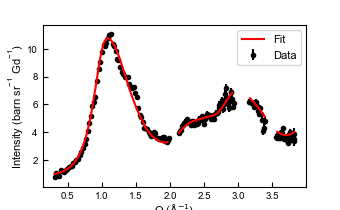

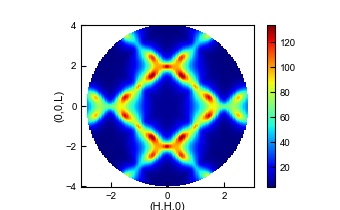

"\nFit using 48 data points, opt_scale, reduced Chi^2 by error\n\nwith Parallel(n_jobs=8) as parallel:\n    res = minimize(lambda x: minTarget_opt_scale(x[0], x[1],x[2],x[3], DipGd, x[4], parallel), \n                   [JexGd,0.01,0.001,0.001, 2.4], \n                   bounds=[(-0.3,0), (-0.02,0.02), (-0.01,0.01),(-0.01,0.01), (0.1,5)], method='Powell')# method = 'Nelder-Mead')\n\n\n4612.034939050674\n[-0.1626426   0.01837789  0.01        0.00479971  2.41644971]\n   direc: array([[ 8.15791686e-04,  1.25317007e-03,  1.39938543e-03,\n        -1.61285438e-04,  4.81209708e-03],\n       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,\n         0.00000000e+00,  1.00000000e+00],\n       [-3.94418570e-05,  1.60010962e-03,  1.95383506e-04,\n         9.17203298e-04, -1.51031265e-03],\n       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,\n         1.00000000e+00,  0.00000000e+00],\n       [ 6.27767760e-09,  6.81001341e-09,  7.06104260e-09,\n         1.12460834e-09,  2.52258312e-08]])\

In [67]:
# print(toc)
# print(res.x)
# print(res)
res.x = [-0.1626426,   0.01837789,  0.01,        0.00479971,  2.41644971]
#Jex1, Jex2, Jex3a, Jex3b, T with scale = 0.1612

latexify()
plt.figure()
plt.errorbar(data[:,0], data[:,1], yerr = data[:,2],color='black', fmt='o',ms=3,label='Data')
#sqs_fit = res.x[0]*np.array(Parallel(n_jobs=8)(delayed(SqPowder_3nnJexDip)(q, res.x[1],res.x[2],res.x[3],res.x[4], DipGd, res.x[5]) for q in data[:,0]*aa))
#sqs_fit = 0.2316*np.array(Parallel(n_jobs=8)(delayed(SqPowder_3nnJexDip)(q, -0.286324,0,0,0, DipGd, 3.356502) for q in data[:,0]*aa))
#sqs_fit = 0.2124*np.array(Parallel(n_jobs=8)(delayed(SqPowder_3nnJexDip)(q, -0.229180,0,0,0, DipGd, 2.899) for q in data[:,0]*aa))
sqs_fit = 0.1612*np.array(
  Parallel(n_jobs=8)(delayed(SqPowder_3nnJexDip)(q, res.x[0],res.x[1],res.x[2],res.x[3], DipGd, res.x[4]) for q in data[:,0]*aa)) # optimiax
x, y = data[:,0], sqs_fit[:,0]
y2 = np.ma.masked_where( ((x>1.978)&(x<2.11)) | ((x>2.93)&(x<3.17)) | ((x>3.5)&(x<3.57)), y) 
plt.plot(data[:,0], y2, c='red', label='Fit', zorder=10)
plt.xlabel(r'Q $(\mathrm{\mathsf{\AA^{-1}}})$', labelpad=1)
plt.ylabel('Intensity (barn sr$^{-1}$ Gd$^{-1}$)', labelpad=1)
plt.legend()
#plt.savefig(data_path.replace('.txt', '_fit_3nn.pdf'),bbox_inches="tight",pad_inches=0.01)
plt.show()

### Plot HHL plane
x = np.linspace(-3, 3, num=121, endpoint=True)
y = np.linspace(-4, 4, num=161, endpoint=True)
X, Y = np.meshgrid(x, y)
#sqs_hhl = np.reshape([Sq_3nnJexDip_fast( 2*np.pi*np.array([i,i,j]),  -0.286324,0,0,0, DipGd, 3.356502) for i in x for j in y], (121, 161))
#sqs_hhl = np.reshape([Sq_3nnJexDip_fast( 2*np.pi*np.array([i,i,j]),  -0.1854,0,0,0, DipGd, 2.543647) for i in x for j in y], (121, 161))
sqs_hhl = np.reshape([Sq_3nnJexDip_fast( 2*np.pi*np.array([i,i,j]),  res.x[0],res.x[1],res.x[2],res.x[3], DipGd, res.x[4]) for i in x for j in y], (121, 161))

rad = np.sqrt(2*X**2 + Y**2)
#Z[(rad>3.8)|(rad<0.33)] = np.nan # for 30mK
Zm = np.ma.masked_where((rad>4)|(rad<0.01),sqs_hhl.T*gdformfact(rad*2*np.pi/aa))# mask Nan values then plot in white color
    
plt.figure()
plt.pcolor(X, Y , Zm, cmap='jet')
plt.gca().set_aspect(0.707)
plt.xlabel('(H,H,0)',labelpad=1)
plt.ylabel('(0,0,L)',labelpad=1)  
plt.colorbar()
#plt.savefig(data_path.replace('.txt', 'hhl_fitted_3nn.pdf'),bbox_inches="tight",pad_inches=0.01)
plt.show()

"""
Fit using 48 data points, opt_scale, reduced Chi^2 by error

with Parallel(n_jobs=8) as parallel:
    res = minimize(lambda x: minTarget_opt_scale(x[0], x[1],x[2],x[3], DipGd, x[4], parallel), 
                   [JexGd,0.01,0.001,0.001, 2.4], 
                   bounds=[(-0.3,0), (-0.02,0.02), (-0.01,0.01),(-0.01,0.01), (0.1,5)], method='Powell')# method = 'Nelder-Mead')


4612.034939050674
[-0.1626426   0.01837789  0.01        0.00479971  2.41644971]
   direc: array([[ 8.15791686e-04,  1.25317007e-03,  1.39938543e-03,
        -1.61285438e-04,  4.81209708e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [-3.94418570e-05,  1.60010962e-03,  1.95383506e-04,
         9.17203298e-04, -1.51031265e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00],
       [ 6.27767760e-09,  6.81001341e-09,  7.06104260e-09,
         1.12460834e-09,  2.52258312e-08]])
     fun: 275.6484290583031
 message: 'Optimization terminated successfully.'
    nfev: 660
     nit: 7
  status: 0
 success: True
       x: array([-0.1626426 ,  0.01837789,  0.01      ,  0.00479971,  2.41644971])
"""


In [25]:
np.savetxt(r'D:\2_Neutron_scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed/sqs_fit.txt',
           np.vstack([data[:,0],sqs_fit[:,0]]).T)
np.savetxt(r'D:\2_Neutron_scattering\2_D7_ILL_Gd2Hf2O7_Feb2020\ILLData_201_d7_exp_5-32-883_processed/sqs_hhl.txt',sqs_hhl)

In [19]:
# Plot fit all 1-3nn Jex and T, scale
resx = np.array([ 1.75710744e-01, -1.64163632e-01,  1.32532963e-03, -4.27739278e-03, -4.77952748e-03,  2.36123390e+00])
# scale, Jex1, Jex2, Jex3a, Jex3b, T

plt.figure()
plt.errorbar(data[:,0], data[:,1], yerr = data[:,2],fmt='o',ms=2,label='Data')
sqs_fit = resx[0]*np.array(Parallel(n_jobs=8)(delayed(SqPowder_3nnJexDip)(q, resx[1],resx[2],resx[3],resx[4], DipGd, resx[5]) for q in data[:,0]*aa))
x, y = data[:,0], sqs_fit[:,0]
y2 = np.ma.masked_where( ((x>2.93)&(x<3.17)) | ((x>3.4)&(x<3.57)), y) 
plt.plot(data[:,0], y2, label='Fit', zorder=10)
plt.xlabel(r'Q $(\mathrm{\mathsf{\AA^{-1}}})$', labelpad=1)
plt.ylabel('Intensity (barn sr$^{-1}$ Gd$^{-1}$)', labelpad=1)
plt.legend()
plt.savefig(data_path.replace('.txt', '_fit_3J.pdf'),bbox_inches="tight",pad_inches=0.01)
plt.show()

x = np.linspace(-3, 3, num=121, endpoint=True)
y = np.linspace(-4, 4, num=161, endpoint=True)
X, Y = np.meshgrid(x, y)
sqs_hhl = np.reshape([Sq_3nnJexDip_fast( 2*np.pi*np.array([i,i,j]), resx[1],resx[2],resx[3],resx[4], DipGd, resx[5] ) for i in x for j in y], (121, 161))
plt.figure()
plt.pcolor(X, Y , sqs_hhl.T, cmap='jet')
plt.gca().set_aspect(0.707)
plt.xlabel('(H,H,0)',labelpad=1)
plt.ylabel('(0,0,L)',labelpad=1)  
plt.colorbar()
#plt.savefig(data_path.replace('.txt', '_hhl_fit_3J.pdf'),bbox_inches="tight",pad_inches=0.01)
plt.show()

"""
Fitting using 20 data points, chi^2 is not divided by error, 1450~function calls

8150.930953741074
[ 1.75710744e-01 -1.64163632e-01  1.32532963e-03 -4.27739278e-03
 -4.77952748e-03  2.36123390e+00]
   direc: array([[ 3.67094226e-03,  4.91562711e-04, -2.91146556e-03,
        -1.65984841e-03, -9.24469566e-04, -1.23492126e-02],
       [ 5.13336999e-04,  4.14505209e-04, -9.66643480e-04,
        -1.43972755e-03, -8.84272048e-04, -8.79723354e-03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [-2.83385280e-03,  1.67103738e-05,  2.24511580e-04,
         9.06828203e-05, -6.05884642e-04,  7.36795671e-04],
       [ 2.11599407e-04,  4.83322830e-05, -2.05019280e-04,
        -1.38454867e-04, -8.42876509e-05, -9.63737220e-04]])
     fun: 3.066245463948997
 message: 'Optimization terminated successfully.'
    nfev: 1557
     nit: 14
  status: 0
 success: True
       x: array([ 1.75710744e-01, -1.64163632e-01,  1.32532963e-03, -4.27739278e-03,
       -4.77952748e-03,  2.36123390e+00])
"""

NameError: name 'SqPowder_3nnJexDip' is not defined

## <a id='toc7_2_'></a>[Fit Jex(1nn) (fixed 1-3nn dipolar and Jex(2nn,3nn)=0)](#toc0_)

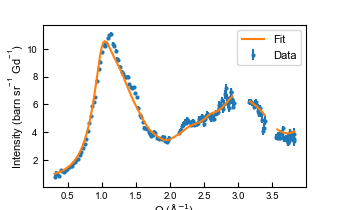

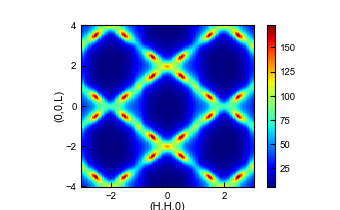

"\n868.1003255844116\n[ 0.1838805  -0.16350477  2.37350717]\n   direc: array([[ 1.60595887e-02,  1.44186171e-03, -2.32946651e-04],\n       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],\n       [ 1.39135317e-03,  1.34843018e-04,  7.83956307e-04]])\n     fun: 4.300482638976829\n message: 'Optimization terminated successfully.'\n    nfev: 272\n     nit: 5\n  status: 0\n success: True\n       x: array([ 0.1838805 , -0.16350477,  2.37350717])\n\n"

In [20]:
# print(toc)
# print(res.x)
# print(res)

resx= np.array([0.1838805, -0.16350477,  2.37350717]) #scale, Jex_1nn, T
plt.figure()
plt.errorbar(data[:,0], data[:,1], yerr = data[:,2],fmt='o',ms=2,label='Data')
sqs_fit = resx[0]*np.array(Parallel(n_jobs=8)(delayed(SqPowder_3nnJexDip)(q, resx[1],0,0,0, DipGd, resx[2]) for q in data[:,0]*aa))
x, y = data[:,0], sqs_fit[:,0]
y2 = np.ma.masked_where( ((x>2.93)&(x<3.17)) | ((x>3.4)&(x<3.57)), y) 
plt.plot(data[:,0], y2, label='Fit', zorder=10)
plt.xlabel(r'Q $(\mathrm{\mathsf{\AA^{-1}}})$', labelpad=1)
plt.ylabel('Intensity (barn sr$^{-1}$ Gd$^{-1}$)', labelpad=1)
plt.legend()
#plt.savefig(data_path.replace('.txt', '_fit_nnJex_fixed_3nnDip.pdf'),bbox_inches="tight",pad_inches=0.01)
plt.show()

x = np.linspace(-3, 3, num=121, endpoint=True)
y = np.linspace(-4, 4, num=161, endpoint=True)
X, Y = np.meshgrid(x, y)
sqs_hhl = np.reshape([Sq_3nnJexDip_fast( 2*np.pi*np.array([i,i,j]), resx[1],0,0,0, DipGd, resx[2] ) for i in x for j in y], (121, 161))
plt.figure()
plt.pcolor(X, Y, sqs_hhl.T, cmap='jet')
plt.gca().set_aspect(0.707)
plt.xlabel('(H,H,0)',labelpad=1)
plt.ylabel('(0,0,L)',labelpad=1)  
plt.colorbar()
#plt.savefig(data_path.replace('.txt', '_hhl_fit_nnJex_fixed_3nnDip.pdf'),bbox_inches="tight",pad_inches=0.01)
plt.show()

"""
868.1003255844116
[ 0.1838805  -0.16350477  2.37350717]
   direc: array([[ 1.60595887e-02,  1.44186171e-03, -2.32946651e-04],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 1.39135317e-03,  1.34843018e-04,  7.83956307e-04]])
     fun: 4.300482638976829
 message: 'Optimization terminated successfully.'
    nfev: 272
     nit: 5
  status: 0
 success: True
       x: array([ 0.1838805 , -0.16350477,  2.37350717])

"""

# <a id='toc8_'></a>[Fit nn Jex and Dip](#toc0_)

## <a id='toc8_1_'></a>[Fit nn Jex and Dip](#toc0_)

In [ ]:
# Memorize the timeing consuming powder average result if only scale is changed while fitting
# https://www.python-course.eu/python3_memoization.php
class Memoize:
    def __init__(self, fn):
        self.fn = fn
        self.memo = {}
        self.count = 0
    def __call__(self, *args):
        self.count += 1
        call_time = time.localtime()
        print(time.strftime("%d %b %Y %H:%M:%S, ", call_time), 'Function call count: %3d， ' % self.count,
              'fit parameters are %1.8f, %1.8f, %1.8f, %1.8f' % (args[0],args[1],args[2], args[3]))
        if args[1:4] not in self.memo:
            #print("is not in previous")
            self.memo[args[1:4]] = self.fn(*args)/args[0]
        #else: 
            #print('is in previous')
        print('run time(s): ', time.mktime(time.localtime())-time.mktime(call_time))
        return args[0]*self.memo[args[1:4]]

@Memoize
def parSqs(scale, Jex, Dip, T, parallel):
    return scale*np.array(parallel(delayed(SqPowder_nnJexDip)(q, Jex, Dip, T) for q in data_part[:,0]))[:,0]

# Q points for testing if the setted parameters gives negative intensity
x = np.linspace(0.1, 3, num=30, endpoint=True)
y = np.linspace(0.1, 4, num=40, endpoint=True)
hhl = np.array([2*np.pi*np.array([i,i,j]) for i in x for j in y])
large_return_for_improper_pars = 1000*np.sum(data_part[:,1]**2)

def minTarget(scale, Jex, Dip, T, parallel):
    #print(time.strftime("%a, %d %b %Y %H:%M:%S, ", time.gmtime()), 'fit parameters are %1.4f, %1.4f, %1.4f' % (scale, Jex, T))
    # Do not calculate powder average for imporper parameters while fitting: if contains negative intensity, wrong and timing consuming
    if np.any(np.array(parallel(delayed(Sq_nnJexDip_fast)(q, Jex, Dip, T) for q in hhl)) <0):
        print(time.strftime("%d %b %Y %H:%M:%S, ", time.localtime()), 'Negtive intensity, Powder function not called',
              'fit parameters are %1.8f, %1.8f, %1.8f, %1.8f' % (scale, Jex, Dip, T))
        #print('Negtive intensity, return a large number instead of calc. Sq_powder')
        return large_return_for_improper_pars
    else:
        sqs = parSqs(scale, Jex, Dip, T, parallel)
        target = np.sum((sqs-data_part[:,1])**2)
        print('Chi^2: %10.4f' % target)
        return target

In [ ]:
%time sqs = np.array(Parallel(n_jobs=8)(delayed(SqPowder_JexDip)(i, JexGd, DipGd, 2.7) for i in data_part[:,0]))

In [ ]:
plt.figure()
plt.plot(data_part[:,0], data_part[:,1])
plt.plot(data_part[:,0], sqs[:,0]*0.3)
print(np.sum((data_part[:,1]- sqs[:,0]*0.3)**2))
plt.show()

In [ ]:
# Test minTarget
with Parallel(n_jobs=8) as parallel:
    print(minTarget(0.3, JexGd, DipGd, 2.57, parallel))

In [ ]:
from scipy.optimize import minimize

tic = time.time()
with Parallel(n_jobs=8) as parallel:
    res = minimize(lambda x: minTarget(x[0], x[1], DipGd, x[2], parallel), [0.3, JexGd, 2.7], bounds=[(0,np.inf), (-0.3,0), (0.1,5)], method='Powell')# method = 'Nelder-Mead')
toc = time.time()-tic

In [ ]:
print(toc)
print(res.x)
print(res)

plt.figure()
plt.errorbar(data[:,0], data[:,1], yerr = data[:,2],fmt='o',ms=2,label='Data')
#sqs_fit = res.x[0]*np.array(Parallel(n_jobs=8)(delayed(SqPowder_nnJexDip)(q, res.x[1], DipGd, res.x[2]) for q in data[:,0]*aa))
x, y = data[:,0], sqs_fit[:,0]
y2 = np.ma.masked_where( ((x>2.93)&(x<3.17)) | ((x>3.4)&(x<3.57)), y) 
plt.plot(data[:,0], y2, label='Fit', zorder=10)
plt.xlabel(r'Q $(\mathrm{\mathsf{\AA^{-1}}})$', labelpad=1)
plt.ylabel('Intensity (barn sr$^{-1}$ Gd$^{-1}$)', labelpad=1)
plt.legend()
plt.savefig(data_path.replace('.txt', 'fit.pdf'),bbox_inches="tight",pad_inches=0.01)
plt.show()

x = np.linspace(-3, 3, num=121, endpoint=True)
y = np.linspace(-4, 4, num=161, endpoint=True)
X, Y = np.meshgrid(x, y)
#sqs_hhl = np.reshape([Sq_nnJexDip_fast( 2*np.pi*np.array([i,i,j]), res.x[1], DipGd, res.x[2] ) for i in x for j in y], (121, 161))
plt.figure()
plt.pcolor(X, Y , sqs_hhl.T, cmap='jet')
plt.gca().set_aspect(0.707)
plt.xlabel('(H,H,0)',labelpad=1)
plt.ylabel('(0,0,L)',labelpad=1)  
plt.colorbar()
plt.savefig(data_path.replace('.txt', 'hhl_fitted.pdf'),bbox_inches="tight",pad_inches=0.01)
plt.show()

## <a id='toc8_2_'></a>[Fit only nn Jex](#toc0_)

In [ ]:
%time sqs = np.array(Parallel(n_jobs=8)(delayed(SqPowder)(i, -0.166, 1.3) for i in data_part[:,0]))

In [22]:
# Plot as a function of temperature
plt.figure()
plt.plot(data_part[:,0], data_part[:,1])
with Parallel(n_jobs=8) as parallel:
    for T in [1.3,1.5,1.7,2.0,2.5,3.0,4.0,5.0]:
        sqs = np.array(parallel(delayed(SqPowder)(i, -0.166, T) for i in data_part[:,0]))
        plt.plot(data_part[:,0], sqs[:,0]*0.015)
        plt.show()

In [ ]:
# test target
np.sum((data_part[:,1]-sqs[:,0]*0.015)**2)

In [ ]:
#@jit(parallel=True,nopython=False)
def minTarget_jitted(scale, Jex, T):# not working becouase of nquad not work with numba
    target = 0
    # Without "parallel=True" in the jit-decorator the prange statement is equivalent to range
    for i in prange(data_part.shape[0]):
         target += (SqPowder(data_part[i,0], Jex, T)-data_part[i,1])**2
    return target  

# Memorize the timeing consuming powder average result if only scale is changed while fitting
# https://www.python-course.eu/python3_memoization.php
class Memoize:
    def __init__(self, fn):
        self.fn = fn
        self.memo = {}
        self.count = 0
    def __call__(self, *args):
        self.count += 1
        print(time.strftime("%d %b %Y %H:%M:%S, ", time.localtime()), 'Function call count: %3d， ' % self.count, 'fit parameters are %1.8f, %1.8f, %1.8f' % (args[0],args[1],args[2]))
        if args[1:3] not in self.memo:
            print("is not in previous")
            self.memo[args[1:3]] = self.fn(*args)/args[0]
        else:
            print('is in previous')
        return args[0]*self.memo[args[1:3]]
    
@Memoize
def parSqs(scale, Jex, T, parallel):
    return scale*np.array(parallel(delayed(SqPowder)(q, Jex, T) for q in data_part[:,0]))[:,0]
    
def minTarget(scale, Jex, T, parallel):
    #print(time.strftime("%a, %d %b %Y %H:%M:%S, ", time.gmtime()), 'fit parameters are %1.4f, %1.4f, %1.4f' % (scale, Jex, T))
    target = 0
    sqs = parSqs(scale, Jex, T, parallel)
    target = np.sum((sqs-data_part[:,1])**2)
    return target


In [ ]:
# Test minTarget
with Parallel(n_jobs=8) as parallel:
    print(minTarget(0.015, -0.166, 1.3, parallel))

In [ ]:
from scipy.optimize import minimize

tic = time.time()
with Parallel(n_jobs=8) as parallel:
    res = minimize(lambda x: minTarget(x[0], x[1], 1.3, parallel), [0.015, -0.16], bounds=[(0,np.inf), (-0.3,0)], method='Powell')# method = 'Nelder-Mead')
toc = time.time()-tic

In [ ]:
print(toc)
print(res.x)
print(res)

In [ ]:
with Parallel(n_jobs=8) as parallel:
    print(minTarget(*res.x, 1.3, parallel))

In [ ]:
plt.figure()
plt.plot(data_part[:,0], data_part[:,1])
sqs = res.x[0]*np.array(Parallel(n_jobs=8)(delayed(SqPowder)(q, res.x[1], 1.3) for q in data_part[:,0]))
plt.plot(data_part[:,0], sqs[:,0])
plt.show()

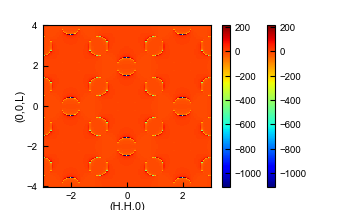

In [21]:
x = np.linspace(-3, 3, num=121, endpoint=True)
y = np.linspace(-4, 4, num=161, endpoint=True)
X, Y = np.meshgrid(x, y)
sqs = np.reshape([SqFast( 2*np.pi*np.array([i,i,j]), -0.185, 1.45) for i in x for j in y], (121, 161))

plt.figure()
plt.pcolor(X, Y , sqs.T,cmap='jet')
plt.colorbar()
plt.xlabel('(H,H,0)',labelpad=1)
plt.ylabel('(0,0,L)',labelpad=1)  
plt.colorbar()
# plt.savefig(data_path.replace('.txt', '_hhl_only_nnJex.pdf'),bbox_inches="tight",pad_inches=0.01)
plt.show()

In [ ]:
%%time
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Call instance of PSO
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=2, options=options)

# Perform optimization
cost, pos = optimizer.optimize(fx.sphere, iters=1000)

# <a id='toc9_'></a>[Random fitting](#toc0_)

In [86]:
x = np.linspace(0.1, 3, num=30, endpoint=True)
y = np.linspace(0.1, 4, num=40, endpoint=True)
hhl = np.array([2*np.pi*np.array([i,i,j]) for i in x for j in y])

def check_opt_scale(Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T, parallel):
    # Do not calculate powder average for improper parameters while fitting: if contains negative intensity, wrong and timing consuming
    if np.any(np.array(parallel(delayed(Sq_3nnDaJexDip_fast)(q, Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T) for q in hhl)) <0):
        #print(time.strftime("%d %b %Y %H:%M:%S, ", time.localtime()), 'Negtive intensity, Powder function not called',
        #      'fit parameters are '+' '.join('{:1.6f}'.format(k) for k in [Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T]))
        return [False]
    else:
        sqs = parSqs(1.0, Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T, parallel)
        res = minimize(lambda scale: np.sum( ((scale*sqs-data_part[:,1])/data_part[:,2])**2 ), [0.16], bounds=[(0,np.inf)]) # reduced by errorbar
        
        print('Chi^2: %10.4f, Scale: %1.4f, Opt_scale Success: %s' % (res.fun, res.x[0], res.success))
        print('Fit parameters are '+' '.join('{:1.6f}'.format(k) for k in [Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T]))
        #          0       1       2     3   4   5     6      7   8   9
        return res.fun, res.x[0], Da, Jex0,Jex1,Jex2a,Jex2b, Dip, T, True

In [87]:
parSqs.refresh()
record = []

iters=0
max_iters = 4000
with Parallel(n_jobs=8) as parallel:
    while iters<max_iters:
        rd = (np.random.rand(4)-0.5)/0.5  # Four random number in range [-1,1]
        # j0, j1, j2a, j2b, T = -0.2*(1+0.5*rd[0]), 0.03*rd[1], 0.03*rd[2], 0.03*rd[3], 3.5-np.random.rand(1)[0]
        # j0, j1, j2a, j2b, T = -0.25+0.1*rd[0], 0.02*rd[1], 0.02*rd[2], 0.02*rd[3], 3.5-np.random.rand(1)[0]
        j0, j1, j2a, j2b, T = -0.225+0.075*rd[0], 0.02*rd[1], 0.02*rd[2], 0.01*rd[3], 3.5-np.random.rand(1)[0]
        # TODO: random with fiting T
        res = check_opt_scale(DanGd, j0, j1, j2a,j2b, DipGd, T, parallel)
        if res[-1]:
            record.append(res)
            iters+=1
        else:
            continue
    
record = np.array(record)     

with open(os.path.join(fpath, 'random_3000.txt'), "ab") as f:
    #f.write(b"\n")
    np.savetxt(f, record)
    
f.close()   

25 Nov 2023 08:40:49,  Function call count:   1,  fit parameters are 1.000000 0.003362 -0.235364 -0.006438 -0.015336 -0.005968 0.066000 3.447160
run time(s):  0.0
Chi^2:  6061.0311, Scale: 0.4538, Opt_scale Success: True
Fit parameters are 0.003362 -0.235364 -0.006438 -0.015336 -0.005968 0.066000 3.447160
25 Nov 2023 08:40:52,  Function call count:   2,  fit parameters are 1.000000 0.003362 -0.263120 -0.016183 -0.018842 0.007989 0.066000 3.266491
run time(s):  0.0
Chi^2:  2695.0432, Scale: 0.3416, Opt_scale Success: True
Fit parameters are 0.003362 -0.263120 -0.016183 -0.018842 0.007989 0.066000 3.266491
25 Nov 2023 08:40:58,  Function call count:   3,  fit parameters are 1.000000 0.003362 -0.159543 -0.004853 -0.000266 -0.008953 0.066000 3.294995
run time(s):  0.0
Chi^2: 11958.7255, Scale: 0.5209, Opt_scale Success: True
Fit parameters are 0.003362 -0.159543 -0.004853 -0.000266 -0.008953 0.066000 3.294995
25 Nov 2023 08:41:01,  Function call count:   4,  fit parameters are 1.000000 0.0

c:\Users\jhxup\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Chi^2:        nan, Scale: 0.1600, Opt_scale Success: False
Fit parameters are 0.003362 -0.176616 0.017969 -0.017372 -0.009561 0.066000 2.593687
25 Nov 2023 09:17:51,  Function call count:  39,  fit parameters are 1.000000 0.003362 -0.152730 -0.009298 0.001811 -0.004470 0.066000 2.681060
run time(s):  0.0
Chi^2:  7036.6257, Scale: 0.3613, Opt_scale Success: False
Fit parameters are 0.003362 -0.152730 -0.009298 0.001811 -0.004470 0.066000 2.681060
25 Nov 2023 09:17:57,  Function call count:  40,  fit parameters are 1.000000 0.003362 -0.174704 -0.015588 0.007670 -0.004743 0.066000 2.649459
run time(s):  0.0
Chi^2:  2926.8435, Scale: 0.2582, Opt_scale Success: True
Fit parameters are 0.003362 -0.174704 -0.015588 0.007670 -0.004743 0.066000 2.649459
25 Nov 2023 09:18:22,  Function call count:  41,  fit parameters are 1.000000 0.003362 -0.169442 0.017363 0.011308 -0.008834 0.066000 3.142590
run time(s):  0.0
Chi^2:  7268.7423, Scale: 0.4478, Opt_scale Success: True
Fit parameters are 0.00336

In [13]:
record[np.nanargmin(record[:,0]),:]

array([ 4.30516402e+02,  1.93114593e-01,  3.36206897e-03, -2.13414309e-01,
        1.51673109e-02,  9.72959299e-03,  4.66870300e-04,  6.60000000e-02,
        2.82552556e+00,  1.00000000e+00])

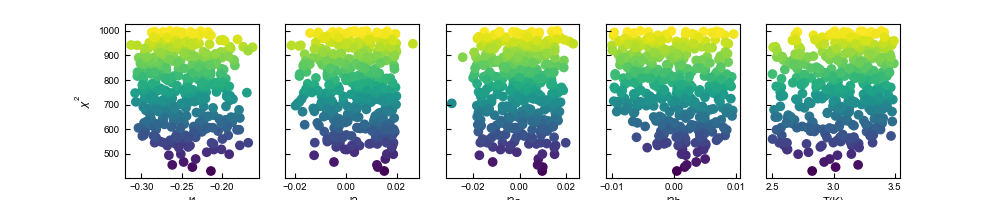

In [3]:
# Polt chi2-parameter subplots
fpath = r'D:\2_Neutron_scattering\2_D7_ILL_Gd2Hf2O7_Feb2020'
record = np.genfromtxt(os.path.join(fpath,'random_3000.txt'))

fig, axs = plt.subplots(figsize=(10,2), nrows=1, ncols=5, sharey=True)
lables = ['J1','J2', 'J3a', 'J3b','T(K)']

for ax,lable in zip(axs, lables):
    ax.set_xlabel(lable)
axs[0].set_ylabel('$\chi^2$')

record = np.array(record)
ma0 = record[:,0]<1000
ma1 = (record[:,6]>-0.01) & (record[:,6]<0.01)
ma = ma0 & ma1
for idx, i in enumerate([3,4,5,6,8]):
    axs[idx].scatter(record[ma,i], record[ma,0],  c=record[ma,0], cmap='viridis')
#fig.savefig(os.path.join(fpath,'random_fit_chi_pars.pdf'),bbox_inches="tight",pad_inches=0.01)    
plt.show()

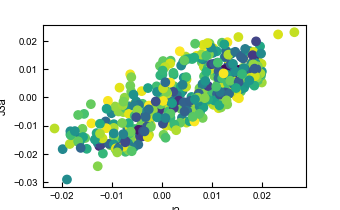

In [4]:
# A slice of J2-J3a at J1, J3b and T
fig, ax = plt.subplots()
lables = ['J1','J2', 'J3a', 'J3b','T(K)']

pars = [-1.948e-01, 1.891e-02, 1.320e-02, 2.325e-03, 2.699]

ax.set_xlabel('J2')
ax.set_ylabel('J3a')

record = np.array(record)
ma0 = record[:,0]<1000
ma3 = (record[:,3]>pars[0]*1.1) & (record[:,3]<pars[0]*0.9)
ma6 = (record[:,6]>pars[3]*0.9) & (record[:,6]<pars[3]*1.1)
ma8 = (record[:,8]>pars[4]*0.9) & (record[:,8]<pars[4]*1.1)

ma = ma0 #& ma3 & ma6 & ma8
ax.scatter(record[ma,4], record[ma,5],  c=record[ma,0], cmap='viridis')
    
plt.show()

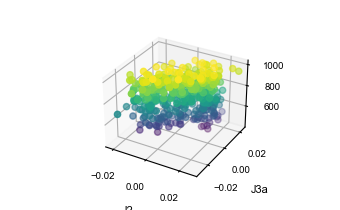

In [5]:
# 3D plot
ax = plt.figure().add_subplot(projection='3d')
lables = ['Scale','J1','J2', 'J3a', 'J3b','T(K)']

ax.set_xlabel('J2')
ax.set_ylabel('J3a')

record = np.array(record)
ma0 = record[:,0]<1000
ma = ma0
ax.scatter(record[ma,4], record[ma,5], record[ma,0], c=record[ma,0], cmap='viridis')
    
plt.show()

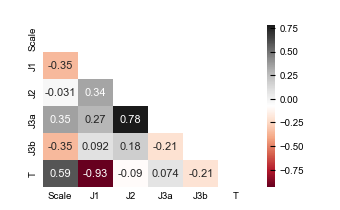

In [9]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(data=record[:,[1,3,4,5,6,8]][ma,:], columns=['Scale','J1','J2', 'J3a', 'J3b','T'])
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool),k=0)

fig, ax = plt.subplots()
sns.heatmap(df.corr(), mask=mask, annot=True,cmap='RdGy')
ax.tick_params(left=False, bottom=False)
#fig.savefig(os.path.join(fpath,'random_fit_corr_chi2_less600.pdf'),bbox_inches="tight",pad_inches=0.01)
plt.show()

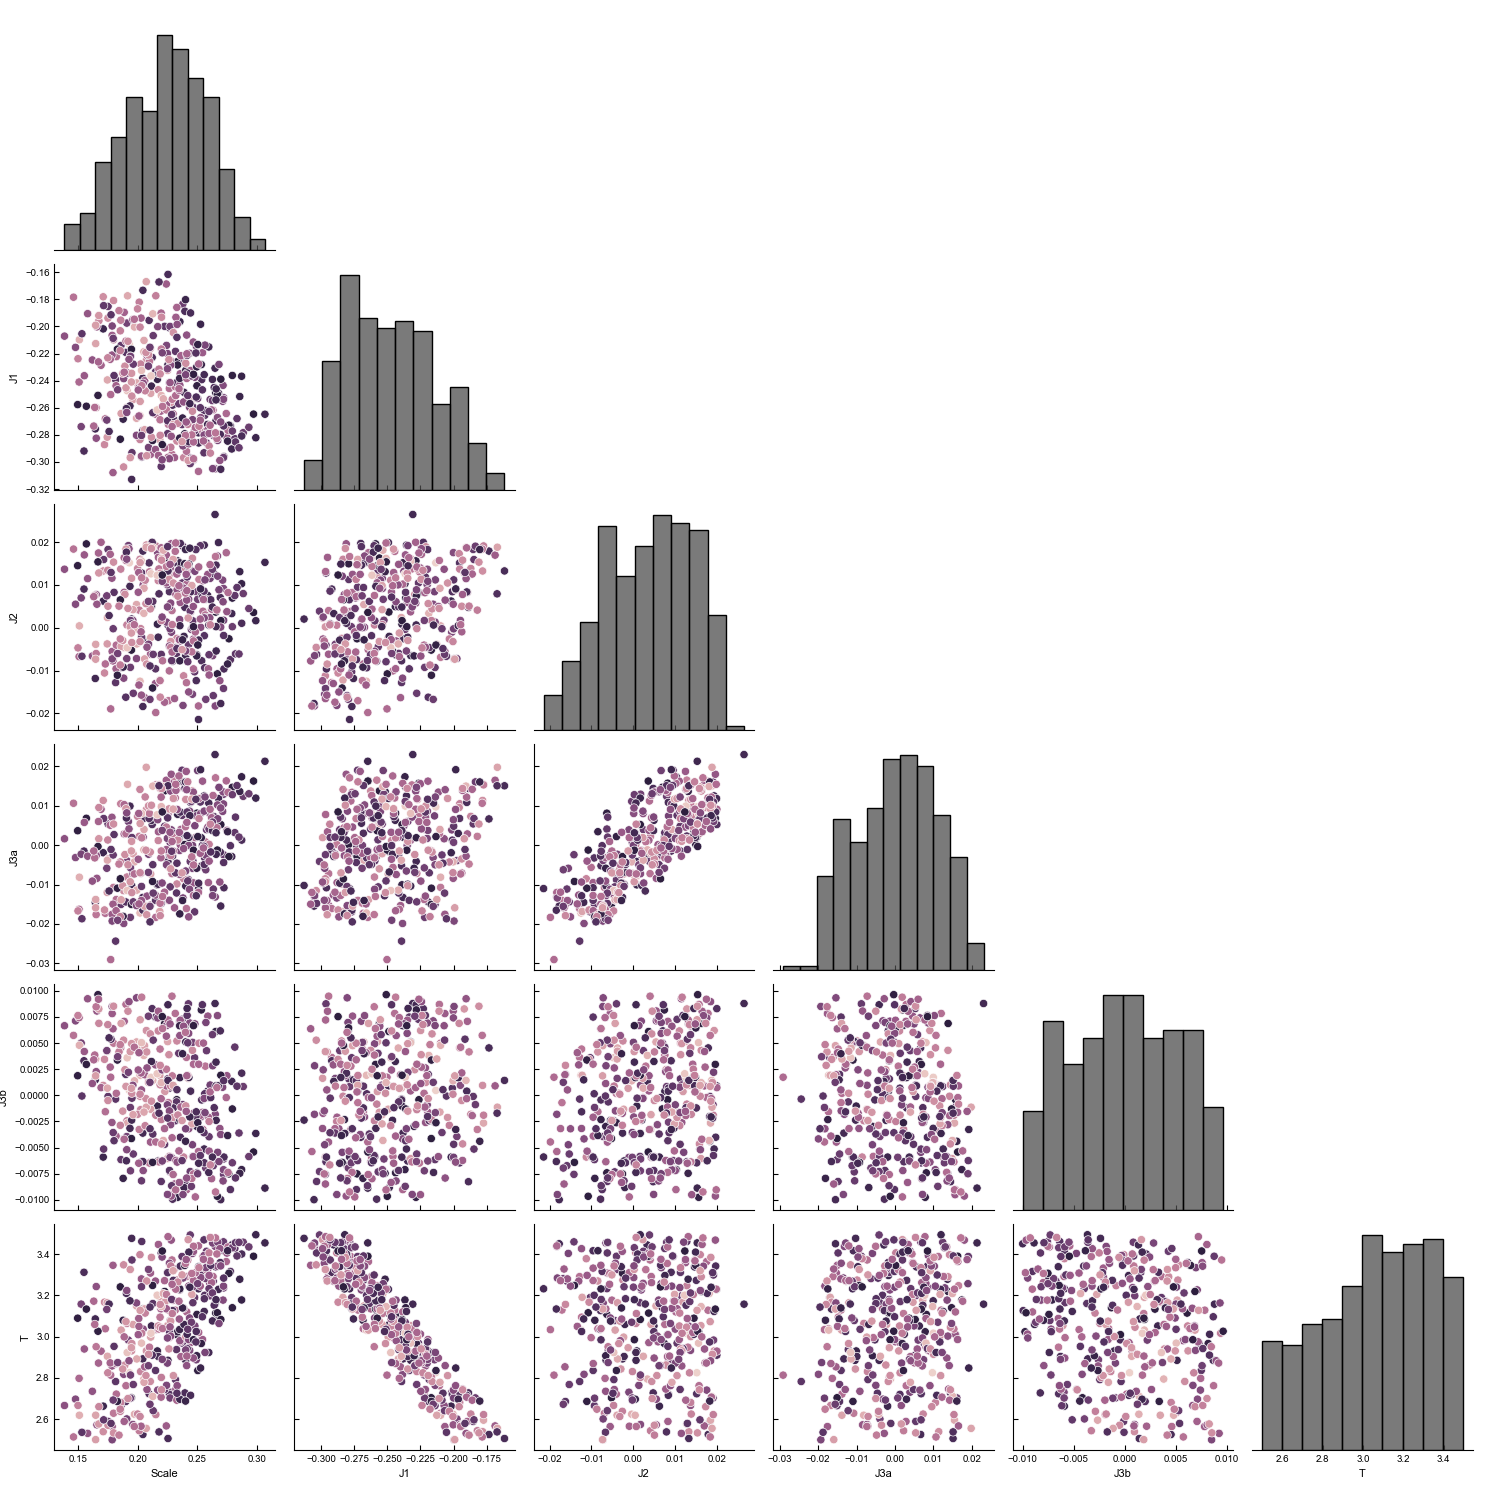

In [95]:
plt.figure(figsize=(4,4))
df = pd.DataFrame(data=record[:,[0,1,3,4,5,6,8]][ma,:], columns=['Chi2','Scale','J1','J2', 'J3a', 'J3b','T'])
g = sns.PairGrid(df, hue='Chi2', diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)
g.map_diag(sns.histplot, hue=None, color=".3")
g.savefig(os.path.join(fpath, 'pair_grid_chi600.pdf'))
plt.show()

In [92]:
print(record[np.nanargmin(record[:,0])])

[ 4.30516402e+02  1.93114593e-01  3.36206897e-03 -2.13414309e-01
  1.51673109e-02  9.72959299e-03  4.66870300e-04  6.60000000e-02
  2.82552556e+00  1.00000000e+00]


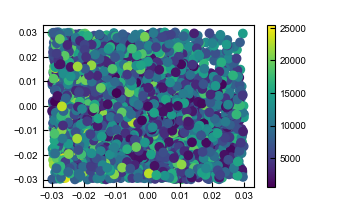

In [152]:
fig, ax = plt.subplots()
sc = ax.scatter(record[:,5], record[:,6], c=record[:,0], cmap='viridis')
plt.colorbar(sc)
plt.show()